# Credits
> This code is a slight modification to a translation (TensorFlow --> PyTorch) of a previous version of the [02456](http://kurser.dtu.dk/course/02456) course material. 
> [Original repo link (TensorFlow)](https://github.com/DeepLearningDTU/02456-deep-learning).
> [Translated repo link (PyTorch)](https://github.com/munkai/pytorch-tutorial/tree/master/2_intermediate).

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from torch.nn.parameter import Parameter
from torchvision.datasets import MNIST

# MNIST dataset
MNIST is a dataset that is often used for benchmarking. The MNIST dataset consists of 70,000 images of handwritten digits from 0-9. The dataset is split into a 50,000 images training set, 10,000 images validation set and 10,000 images test set. The images are 28x28 pixels, where each pixel represents a normalised value between 0-255 (0=black and 255=white).

![MNIST.Exampel](../static_files/mnist.png)


## Primer
We use a feedforward neural network to classify the 28x28 mnist images. `num_features` is therefore $28 * 28=784$, i.e. we represent each image as a vector. The ordering of the pixels in the vector does not matter, so we could permutate all images using the same permutation and still get the same performance. (You are of course encouraged to try this using ``numpy.random.permutation`` to get a random permutation. This task is therefore called the _permutation invariant_ MNIST. Obviously this throws away a lot of structure in the data. In the next module we'll fix this with the convolutional neural network wich encodes prior knowledgde about data that has either spatial or temporal structure.  

## MNIST
First let's load the MNIST dataset and plot a few examples:

In [9]:
mnist_trainset = MNIST("./temp/", train=True, download=True)
mnist_testset = MNIST("./temp/", train=False, download=True)

In [10]:
# To speed up training we'll only work on a subset of the data
x_train = mnist_trainset.data[:1000].view(-1, 784).float()
targets_train = mnist_trainset.targets[:1000]

x_valid = mnist_trainset.data[1000:1500].view(-1, 784).float()
targets_valid = mnist_trainset.targets[1000:1500]

x_test = mnist_testset.data[:500].view(-1, 784).float()
targets_test = mnist_testset.targets[:500]

print("Information on dataset")
print("x_train", x_train.shape)
print("targets_train", targets_train.shape)
print("x_valid", x_valid.shape)
print("targets_valid", targets_valid.shape)
print("x_test", x_test.shape)
print("targets_test", targets_test.shape)

# normalize the inputs
x_train.div_(255)
x_valid.div_(255)
x_test.div_(255)

Information on dataset
x_train torch.Size([1000, 784])
targets_train torch.Size([1000])
x_valid torch.Size([500, 784])
targets_valid torch.Size([500])
x_test torch.Size([500, 784])
targets_test torch.Size([500])


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

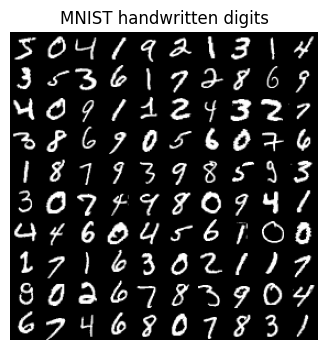

In [11]:
# plot a few MNIST examples
idx, dim, classes = 0, 28, 10
# create empty canvas
canvas = np.zeros((dim*classes, classes*dim))

# fill with tensors
for i in range(classes):
    for j in range(classes):
        canvas[i*dim:(i+1)*dim, j*dim:(j+1)*dim] = x_train[idx].reshape((dim, dim))
        idx += 1

# visualize matrix of tensors as gray scale image
plt.figure(figsize=(4, 4))
plt.axis('off')
plt.imshow(canvas, cmap='gray')
plt.title('MNIST handwritten digits')
plt.show()

## Model

One of the large challenges in deep learning is the amount of hyperparameters that needs to be selected, and the lack of a good principled way of selecting them.
Hyperparameters can be found by experience (guessing) or some search procedure (often quite slow).
Random search is easy to implement and performs decent: http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf . 
More advanced search procedures include [Spearmint](https://github.com/JasperSnoek/spearmint) and many others.

**In practice a lot of trial and error is almost always involved.** This can be frustrating and time consuming, but the best thing to do is to think as a scientist, and go about it in a ordered manner --> monitor as much as you can, take notes, and be deliberate!

Below are some guidelines that you can use as a starting point to some of the most important hyperparameters. 
(*regularization* is also very important, but will be covered later.)


### Ballpark estimates of hyperparameters
__Number of hidden units and network structure:__
You'll have to experiment. One rarely goes below 512 units for feedforward networks (unless your are training on CPU...).
There's some research into stochastic depth networks: https://arxiv.org/pdf/1603.09382v2.pdf, but in general this is trial and error.

__Parameter initialization:__
Parameter initialization is extremely important.
PyTorch has a lot of different initializers, check the [PyTorch API](http://pytorch.org/docs/master/nn.html#torch-nn-init). Often used initializer are
1. Kaiming He
2. Xavier Glorot
3. Uniform or Normal with small scale (0.1 - 0.01)
4. Orthogonal (this usually works very well for RNNs)

Bias is nearly always initialized to zero using the [torch.nn.init.constant(tensor, val)](http://pytorch.org/docs/master/nn.html#torch.nn.init.constant)

__Mini-batch size:__
Usually people use 16-256. Bigger is not allways better. With smaller mini-batch size you get more updates and your model might converge faster. Also small batch sizes use less memory, which means you can train a model with more parameters.

__Nonlinearity:__ [The most commonly used nonliearities are](http://pytorch.org/docs/master/nn.html#non-linear-activations)
1. ReLU
2. Leaky ReLU
3. ELU
3. Sigmoid (rarely, if ever, used in hidden layers anymore, squashes the output to the interval [0, 1] - appropriate if the targets are binary.
4. Tanh is similar to the sigmoid, but squashes to [-1, 1]. Rarely used any more.
4. Softmax normalizes the output to 1, usrful if you have a multi-class classification problem.

See the plot below.

__Optimizer and learning rate:__
1. SGD + Momentum: learning rate 0.01 - 0.1 
2. ADAM: learning rate 3e-4 - 1e-5
3. RMSPROP: somewhere between SGD and ADAM


softmax should sum to one (approxiamtely): 1.0


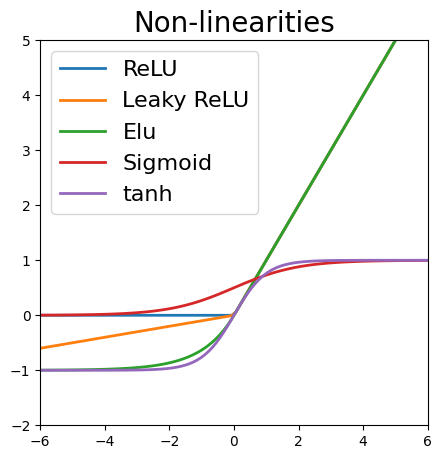

In [12]:
# Illustrate different output units
x = np.linspace(-6, 6, 100)
units = {
    "ReLU": lambda x: np.maximum(0, x),
    "Leaky ReLU": lambda x: np.maximum(0, x) + 0.1 * np.minimum(0, x),
    "Elu": lambda x: (x > 0) * x + (1 - (x > 0)) * (np.exp(x) - 1),
    "Sigmoid": lambda x: (1 + np.exp(-x))**(-1),
    "tanh": lambda x: (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
}

plt.figure(figsize=(5, 5))
[plt.plot(x, unit(x), label=unit_name, lw=2) for unit_name, unit in units.items()]
plt.legend(loc=2, fontsize=16)
plt.title('Non-linearities', fontsize=20)
plt.ylim([-2, 5])
plt.xlim([-6, 6])

# assert that all class probablities sum to one
softmax = lambda x: np.exp(x) / np.sum(np.exp(x))
print("softmax should sum to one (approxiamtely):", np.sum(softmax(x)))

In [13]:
#Hyperparameters
num_classes = 10
num_l1 = 512
num_features = x_train.shape[1]

# define network
class Net(nn.Module):

    def __init__(self, num_features, num_hidden, num_output):
        super(Net, self).__init__()  
        # input layer
        self.W_1 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden, num_features)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden), 0))
        # hidden layer
        self.W_2 = Parameter(init.xavier_normal_(torch.Tensor(num_output, num_hidden)))
        self.b_2 = Parameter(init.constant_(torch.Tensor(num_output), 0))
        # define activation function in constructor
        self.activation = torch.nn.ELU()

    def forward(self, x):
        x = F.linear(x, self.W_1, self.b_1)
        x = self.activation(x)
        x = F.linear(x, self.W_2, self.b_2)
        x = F.softmax(x, dim=1)
        return x


net = Net(num_features, num_l1, num_classes)

In [14]:
optimizer = optim.SGD(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [15]:
# Test the forward pass with dummy data
x = np.random.normal(0, 1, (45, dim*dim)).astype('float32')

print(net(torch.from_numpy(x)).size())

torch.Size([45, 10])


# Build the training loop

We train the network by calculating the gradient w.r.t the cost function and update the parameters in direction of the negative gradient. 


When training neural network you always use mini batches. Instead of calculating the average gradient using the entire dataset you approximate the gradient using a mini-batch of typically 16 to 256 samples. The paramters are updated after each mini batch. Networks converge much faster using mini batches because the parameters are updated more often.

We build a loop that iterates over the training data. Remember that the parameters are updated each time ``optimizer.step()`` is called.

Epoch  1 : Train Loss 0.229427 , Train acc 0.122000, Valid acc 0.132000
Epoch 11 : Train Loss 0.224085 , Train acc 0.344000, Valid acc 0.348000
Epoch 21 : Train Loss 0.215836 , Train acc 0.461000, Valid acc 0.416000
Epoch 31 : Train Loss 0.207527 , Train acc 0.504000, Valid acc 0.456000
Epoch 41 : Train Loss 0.201759 , Train acc 0.545000, Valid acc 0.512000
Epoch 51 : Train Loss 0.197220 , Train acc 0.602000, Valid acc 0.574000
Epoch 61 : Train Loss 0.193419 , Train acc 0.628000, Valid acc 0.600000
Epoch 71 : Train Loss 0.190735 , Train acc 0.634000, Valid acc 0.606000
Epoch 81 : Train Loss 0.188805 , Train acc 0.640000, Valid acc 0.614000
Epoch 91 : Train Loss 0.187329 , Train acc 0.648000, Valid acc 0.612000
Epoch 101 : Train Loss 0.186108 , Train acc 0.650000, Valid acc 0.612000
Epoch 111 : Train Loss 0.184932 , Train acc 0.658000, Valid acc 0.618000
Epoch 121 : Train Loss 0.183267 , Train acc 0.693000, Valid acc 0.650000
Epoch 131 : Train Loss 0.181297 , Train acc 0.716000, Valid a

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Acc'))

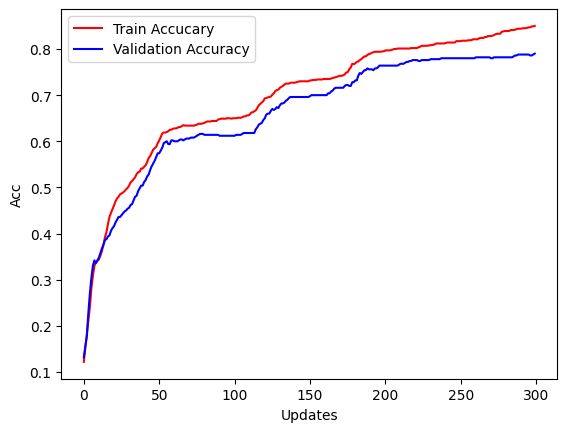

In [16]:
# we could have done this ourselves,
# but we should be aware of sklearn and its tools
from sklearn.metrics import accuracy_score



# setting hyperparameters and gettings epoch sizes
batch_size = 100
num_epochs = 300
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        # compute gradients given loss
        target_batch = targets_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        preds = torch.max(output, 1)[1]
        
        train_targs += list(targets_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(x_valid[slce])
        preds = torch.max(output, 1)[1]
        val_targs += list(targets_valid[slce].numpy())
        val_preds += list(preds.data.numpy())
        

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')

# Assignments

Try and add these modifications (might require some Googleing -- an important skill in deep learning):
- Kaiming He initialization instead of Xavier Glorot
- add an extra layer
- use the relu activation function
- add momentum to the optimizer
- use the ADAM optimizer instead of stochastic gradient descent

### Advanced - Regularization

Regularization is VERY important in practice and is used practically every time.
Many important results are completely dependent on clever use of regularization, and it is something you need to become familiar with if you want to work with deep learning.

- add L1 or L2 weight regularization (aka. weight decay) 
- add dropout to the network (**note** the `net.train()` and `net.eval()` are already in the code)
- add batchnorm

__Pointers on regularization hyperparameter:__
1. L2 and [L1 regularization](http://pytorch.org/docs/master/nn.html#torch.nn.L1Loss) (weight decay of optimization functions) 
  - Normal ranges: 1e-4  -  1e-8
1. [Dropout](http://pytorch.org/docs/master/nn.html?highlight=dropout#torch.nn.Dropout). Dropout rate 0.1-0.5
  - Remember to pick the correct version according to the input dimensionality
  - **NOTE** call `net.train()` before training to activate random dropout, and call `net.eval()` to deactivate dropout while validating or running inference with model.
1. [Batchnorm](http://pytorch.org/docs/master/nn.html#torch.nn.BatchNorm1d): Batchnorm also acts as a regularizer - Often very useful (faster and better convergence)
  - Remember to pick the correct version according to the input dimensionality
  - **NOTE** call `net.train()` before training to activate, and call `net.eval()` to have a non-stochastic variant while validating or running inference with model.
    

### Assignments

For all the following investigations I will use the standard neural network as shown above under "Build the training loop" and only change one thing at a time to investigate their individual effect methodically. Note that I changed the standard neural network to use softmax activation as it is a classification problem. 


I start by redifining the network with Kaiming He Initiliazation

In [17]:
#Hyperparameters
num_classes = 10
num_l1 = 512
num_features = x_train.shape[1]

# define network
class Net(nn.Module):

    def __init__(self, num_features, num_hidden, num_output):
        super(Net, self).__init__()  
        # input layer
        self.W_1 = Parameter(init.kaiming_normal_(torch.Tensor(num_hidden, num_features)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden), 0))
        # hidden layer
        self.W_2 = Parameter(init.kaiming_normal_(torch.Tensor(num_output, num_hidden)))
        self.b_2 = Parameter(init.constant_(torch.Tensor(num_output), 0))
        # define activation function in constructor
        self.activation = torch.nn.ELU()

    def forward(self, x):
        x = F.linear(x, self.W_1, self.b_1)
        x = self.activation(x)
        x = F.linear(x, self.W_2, self.b_2)
        x = F.softmax(x, dim=1)
        return x


net = Net(num_features, num_l1, num_classes)

optimizer = optim.SGD(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()



Epoch  1 : Train Loss 0.229807 , Train acc 0.160000, Valid acc 0.130000
Epoch 11 : Train Loss 0.225262 , Train acc 0.298000, Valid acc 0.252000
Epoch 21 : Train Loss 0.218131 , Train acc 0.434000, Valid acc 0.378000
Epoch 31 : Train Loss 0.209628 , Train acc 0.525000, Valid acc 0.484000
Epoch 41 : Train Loss 0.202369 , Train acc 0.602000, Valid acc 0.562000
Epoch 51 : Train Loss 0.196223 , Train acc 0.655000, Valid acc 0.620000
Epoch 61 : Train Loss 0.191604 , Train acc 0.680000, Valid acc 0.644000
Epoch 71 : Train Loss 0.188284 , Train acc 0.684000, Valid acc 0.656000
Epoch 81 : Train Loss 0.185773 , Train acc 0.698000, Valid acc 0.672000
Epoch 91 : Train Loss 0.183731 , Train acc 0.712000, Valid acc 0.680000
Epoch 101 : Train Loss 0.181914 , Train acc 0.734000, Valid acc 0.688000
Epoch 111 : Train Loss 0.180269 , Train acc 0.749000, Valid acc 0.700000
Epoch 121 : Train Loss 0.178858 , Train acc 0.763000, Valid acc 0.714000
Epoch 131 : Train Loss 0.177645 , Train acc 0.767000, Valid a

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Acc'))

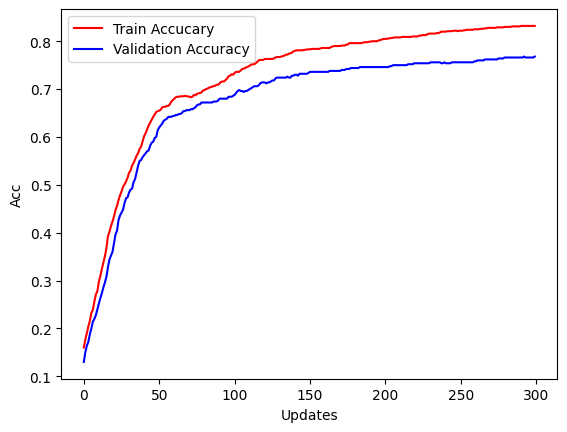

In [18]:
# we could have done this ourselves,
# but we should be aware of sklearn and its tools
from sklearn.metrics import accuracy_score


# setting hyperparameters and gettings epoch sizes
batch_size = 100
num_epochs = 300
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        # compute gradients given loss
        target_batch = targets_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        preds = torch.max(output, 1)[1]
        
        train_targs += list(targets_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(x_valid[slce])
        preds = torch.max(output, 1)[1]
        val_targs += list(targets_valid[slce].numpy())
        val_preds += list(preds.data.numpy())
        

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')

Comparing Kamining He initialization to Xavier Glorot it seems like the difference is slightly worse as the achieved validation accuracy is 0.766 for 300 epochs compared to the xavier of 0.788. However this might be random and thus I cannot decide from this alone if either method is better

I return to the original network except I add an extra layer

In [19]:
#Hyperparameters
num_classes = 10
num_l1 = 512
num_l2 = 512
num_features = x_train.shape[1]

# define network
class Net(nn.Module):

    def __init__(self, num_features, num_hidden1,num_hidden2, num_output):
        super(Net, self).__init__()  
        # input layer
        self.W_1 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden1, num_features)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden1), 0))
        # hidden layer
        self.W_2 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden2, num_hidden1)))
        self.b_2 = Parameter(init.constant_(torch.Tensor(num_hidden2), 0))

        # Another hidden layer
        self.W_3 = Parameter(init.xavier_normal_(torch.Tensor(num_output, num_hidden2)))
        self.b_3 = Parameter(init.constant_(torch.Tensor(num_output), 0))


        # define activation function in constructor
        self.activation = torch.nn.ELU()

    def forward(self, x):
        x = F.linear(x, self.W_1, self.b_1)
        x = self.activation(x)
        x = F.linear(x, self.W_2, self.b_2)
        x = self.activation(x) # added another activation function
        x = F.linear(x, self.W_3, self.b_3) # added another layer
        
        x = F.softmax(x, dim=1)
        return x


net = Net(num_features, num_l1,num_l2, num_classes)

optimizer = optim.SGD(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()



Epoch  1 : Train Loss 0.229983 , Train acc 0.116000, Valid acc 0.090000
Epoch 11 : Train Loss 0.224445 , Train acc 0.405000, Valid acc 0.346000
Epoch 21 : Train Loss 0.214102 , Train acc 0.470000, Valid acc 0.442000
Epoch 31 : Train Loss 0.204845 , Train acc 0.530000, Valid acc 0.502000
Epoch 41 : Train Loss 0.197990 , Train acc 0.593000, Valid acc 0.568000
Epoch 51 : Train Loss 0.192055 , Train acc 0.637000, Valid acc 0.610000
Epoch 61 : Train Loss 0.188532 , Train acc 0.646000, Valid acc 0.612000
Epoch 71 : Train Loss 0.186189 , Train acc 0.653000, Valid acc 0.620000
Epoch 81 : Train Loss 0.184381 , Train acc 0.670000, Valid acc 0.630000
Epoch 91 : Train Loss 0.182713 , Train acc 0.688000, Valid acc 0.646000
Epoch 101 : Train Loss 0.180836 , Train acc 0.706000, Valid acc 0.650000
Epoch 111 : Train Loss 0.177758 , Train acc 0.765000, Valid acc 0.716000
Epoch 121 : Train Loss 0.174055 , Train acc 0.826000, Valid acc 0.780000
Epoch 131 : Train Loss 0.171724 , Train acc 0.837000, Valid a

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Acc'))

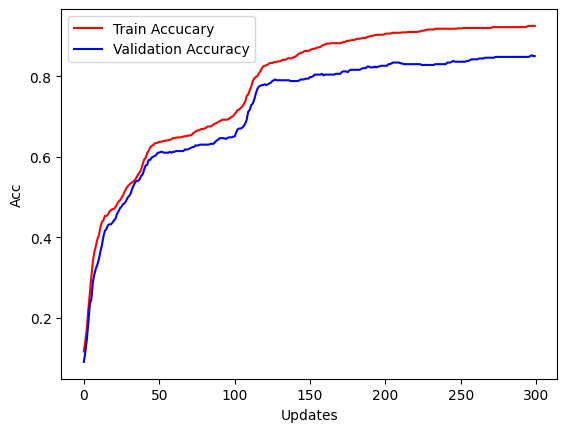

In [20]:
# we could have done this ourselves,
# but we should be aware of sklearn and its tools
from sklearn.metrics import accuracy_score


# setting hyperparameters and gettings epoch sizes
batch_size = 100
num_epochs = 300
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        # compute gradients given loss
        target_batch = targets_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        preds = torch.max(output, 1)[1]
        
        train_targs += list(targets_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(x_valid[slce])
        preds = torch.max(output, 1)[1]
        val_targs += list(targets_valid[slce].numpy())
        val_preds += list(preds.data.numpy())
        

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')

Adding an extra layer to the original network compared to the original with xavier initialization it seems better with a accuracy of 0.848 compared to 0.788 and the accuracy curve does still seem increasing at the stopping epoch. 

Then I try the original network but with Relu activation function instead:

In [21]:
#Hyperparameters
num_classes = 10
num_l1 = 512
num_features = x_train.shape[1]

# define network
class Net(nn.Module):

    def __init__(self, num_features, num_hidden, num_output):
        super(Net, self).__init__()  
        # input layer
        self.W_1 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden, num_features)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden), 0))
        # hidden layer
        self.W_2 = Parameter(init.xavier_normal_(torch.Tensor(num_output, num_hidden)))
        self.b_2 = Parameter(init.constant_(torch.Tensor(num_output), 0))
        # define activation function in constructor
        self.activation = torch.nn.ReLU()

    def forward(self, x):
        x = F.linear(x, self.W_1, self.b_1)
        x = self.activation(x)
        x = F.linear(x, self.W_2, self.b_2)
        x = F.softmax(x, dim=1)
        return x


net = Net(num_features, num_l1, num_classes)

optimizer = optim.SGD(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

Epoch  1 : Train Loss 0.230213 , Train acc 0.137000, Valid acc 0.112000
Epoch 11 : Train Loss 0.228146 , Train acc 0.196000, Valid acc 0.156000
Epoch 21 : Train Loss 0.225394 , Train acc 0.205000, Valid acc 0.156000
Epoch 31 : Train Loss 0.222921 , Train acc 0.281000, Valid acc 0.218000
Epoch 41 : Train Loss 0.220032 , Train acc 0.392000, Valid acc 0.316000
Epoch 51 : Train Loss 0.216356 , Train acc 0.450000, Valid acc 0.410000
Epoch 61 : Train Loss 0.212230 , Train acc 0.468000, Valid acc 0.460000
Epoch 71 : Train Loss 0.208113 , Train acc 0.527000, Valid acc 0.480000
Epoch 81 : Train Loss 0.203957 , Train acc 0.584000, Valid acc 0.544000
Epoch 91 : Train Loss 0.199794 , Train acc 0.637000, Valid acc 0.612000
Epoch 101 : Train Loss 0.195680 , Train acc 0.671000, Valid acc 0.676000
Epoch 111 : Train Loss 0.192056 , Train acc 0.698000, Valid acc 0.678000
Epoch 121 : Train Loss 0.188783 , Train acc 0.719000, Valid acc 0.700000
Epoch 131 : Train Loss 0.185633 , Train acc 0.742000, Valid a

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Acc'))

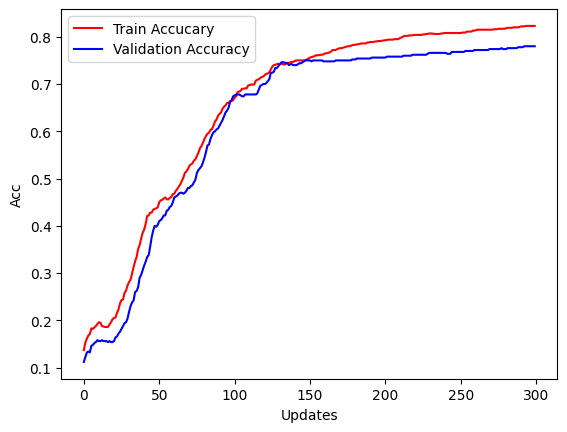

In [22]:
# we could have done this ourselves,
# but we should be aware of sklearn and its tools
from sklearn.metrics import accuracy_score


# setting hyperparameters and gettings epoch sizes
batch_size = 100
num_epochs = 300
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        # compute gradients given loss
        target_batch = targets_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        preds = torch.max(output, 1)[1]
        
        train_targs += list(targets_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(x_valid[slce])
        preds = torch.max(output, 1)[1]
        val_targs += list(targets_valid[slce].numpy())
        val_preds += list(preds.data.numpy())
        

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')

Compared to the original network with Elu activation the network with ReLU seems to have approximately the same validation accuracy. Thus I conclude that changing the activation from ELU to ReLU alone is not provably better on its own. 

Then I try the original network but with momentum to the optimizer SDG

In [23]:
#Hyperparameters
num_classes = 10
num_l1 = 512
num_features = x_train.shape[1]

# define network
class Net(nn.Module):

    def __init__(self, num_features, num_hidden, num_output):
        super(Net, self).__init__()  
        # input layer
        self.W_1 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden, num_features)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden), 0))
        # hidden layer
        self.W_2 = Parameter(init.xavier_normal_(torch.Tensor(num_output, num_hidden)))
        self.b_2 = Parameter(init.constant_(torch.Tensor(num_output), 0))
        # define activation function in constructor
        self.activation = torch.nn.ELU()

    def forward(self, x):
        x = F.linear(x, self.W_1, self.b_1)
        x = self.activation(x)
        x = F.linear(x, self.W_2, self.b_2)
        x = F.softmax(x, dim=1)
        return x


net = Net(num_features, num_l1, num_classes)

optimizer = optim.SGD(net.parameters(), lr=0.01,momentum=0.9)
criterion = nn.CrossEntropyLoss()

Epoch  1 : Train Loss 0.229374 , Train acc 0.204000, Valid acc 0.194000
Epoch 11 : Train Loss 0.183294 , Train acc 0.713000, Valid acc 0.676000
Epoch 21 : Train Loss 0.175032 , Train acc 0.752000, Valid acc 0.704000
Epoch 31 : Train Loss 0.168035 , Train acc 0.829000, Valid acc 0.780000
Epoch 41 : Train Loss 0.164956 , Train acc 0.858000, Valid acc 0.790000
Epoch 51 : Train Loss 0.161765 , Train acc 0.884000, Valid acc 0.824000
Epoch 61 : Train Loss 0.159747 , Train acc 0.897000, Valid acc 0.828000
Epoch 71 : Train Loss 0.157207 , Train acc 0.927000, Valid acc 0.834000
Epoch 81 : Train Loss 0.155826 , Train acc 0.939000, Valid acc 0.836000
Epoch 91 : Train Loss 0.154823 , Train acc 0.945000, Valid acc 0.842000
Epoch 101 : Train Loss 0.153992 , Train acc 0.953000, Valid acc 0.848000
Epoch 111 : Train Loss 0.153337 , Train acc 0.956000, Valid acc 0.852000
Epoch 121 : Train Loss 0.152799 , Train acc 0.961000, Valid acc 0.850000
Epoch 131 : Train Loss 0.152359 , Train acc 0.962000, Valid a

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Acc'))

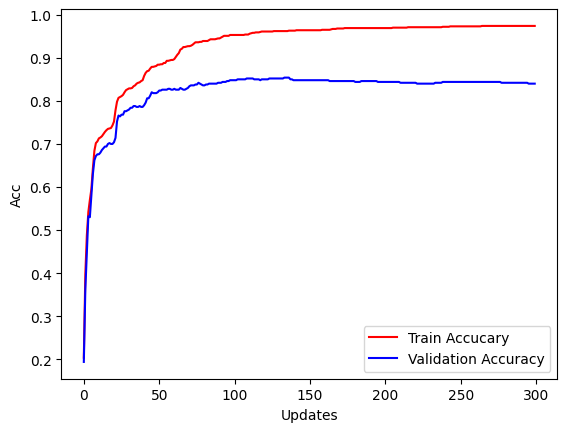

In [24]:
# we could have done this ourselves,
# but we should be aware of sklearn and its tools
from sklearn.metrics import accuracy_score


# setting hyperparameters and gettings epoch sizes
batch_size = 100
num_epochs = 300
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        # compute gradients given loss
        target_batch = targets_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        preds = torch.max(output, 1)[1]
        
        train_targs += list(targets_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(x_valid[slce])
        preds = torch.max(output, 1)[1]
        val_targs += list(targets_valid[slce].numpy())
        val_preds += list(preds.data.numpy())
        

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')

Adding momentum to the original network really seems to help it converge faster as it achieved a higher accuracy around 0.84. However it also seems that the learning curve have saturated. Thus I conclude it helps speeding the learning rate up but that it might not affect the maximum achievable accuracy. 

Last for the regular assignment steps I try to use Adam optimizer for the original network instead of SGD 

Adam use beta values instead of momentum. Here I just use the standard betas = (0.9, 0.999)

In [25]:
#Hyperparameters
num_classes = 10
num_l1 = 512
num_features = x_train.shape[1]

# define network
class Net(nn.Module):

    def __init__(self, num_features, num_hidden, num_output):
        super(Net, self).__init__()  
        # input layer
        self.W_1 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden, num_features)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden), 0))
        # hidden layer
        self.W_2 = Parameter(init.xavier_normal_(torch.Tensor(num_output, num_hidden)))
        self.b_2 = Parameter(init.constant_(torch.Tensor(num_output), 0))
        # define activation function in constructor
        self.activation = torch.nn.ELU()

    def forward(self, x):
        x = F.linear(x, self.W_1, self.b_1)
        x = self.activation(x)
        x = F.linear(x, self.W_2, self.b_2)
        x = F.softmax(x, dim=1)
        return x


net = Net(num_features, num_l1, num_classes)

optimizer = optim.Adam(net.parameters(), lr = 1e-4,betas = (0.9, 0.999))
criterion = nn.CrossEntropyLoss()

Epoch  1 : Train Loss 0.228529 , Train acc 0.309000, Valid acc 0.306000
Epoch 11 : Train Loss 0.180461 , Train acc 0.769000, Valid acc 0.736000
Epoch 21 : Train Loss 0.166760 , Train acc 0.864000, Valid acc 0.834000
Epoch 31 : Train Loss 0.161492 , Train acc 0.905000, Valid acc 0.824000
Epoch 41 : Train Loss 0.157851 , Train acc 0.926000, Valid acc 0.832000
Epoch 51 : Train Loss 0.155437 , Train acc 0.944000, Valid acc 0.850000
Epoch 61 : Train Loss 0.153823 , Train acc 0.954000, Valid acc 0.854000
Epoch 71 : Train Loss 0.152631 , Train acc 0.961000, Valid acc 0.860000
Epoch 81 : Train Loss 0.151737 , Train acc 0.968000, Valid acc 0.852000
Epoch 91 : Train Loss 0.150975 , Train acc 0.970000, Valid acc 0.854000
Epoch 101 : Train Loss 0.150340 , Train acc 0.978000, Valid acc 0.850000
Epoch 111 : Train Loss 0.149858 , Train acc 0.978000, Valid acc 0.850000
Epoch 121 : Train Loss 0.149528 , Train acc 0.979000, Valid acc 0.850000
Epoch 131 : Train Loss 0.149282 , Train acc 0.979000, Valid a

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Acc'))

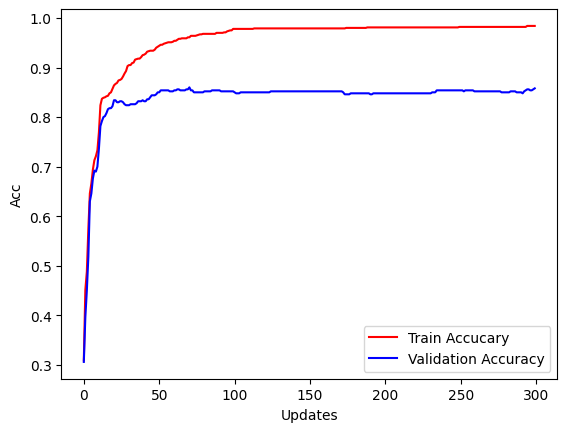

In [26]:


# setting hyperparameters and gettings epoch sizes
batch_size = 100
num_epochs = 300
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        # compute gradients given loss
        target_batch = targets_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        preds = torch.max(output, 1)[1]
        
        train_targs += list(targets_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(x_valid[slce])
        preds = torch.max(output, 1)[1]
        val_targs += list(targets_valid[slce].numpy())
        val_preds += list(preds.data.numpy())
        

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')

Changing the optinmizer to Adam with betas around 0.9, 0.999 achieves the highest accuracy yet compared to the original model of the tried additions with an accuracy of 0.85. I note also that the learning curve seems quickly saturated indicating that the Adam optimizer ensure fast convergence for this problem but that the potential for this version of the network have been reached. 

$\textbf{To get further accuracy I might want to combine some of the additional features such as an extra layer, relu and Adam optimizer.} $

Thus I try to combine Relu, extra layer and Adam optimizer:

In [27]:
#Hyperparameters
num_classes = 10
num_l1 = 512
num_l2 = 512
num_features = x_train.shape[1]

# define network
class Net(nn.Module):

    def __init__(self, num_features, num_hidden1,num_hidden2, num_output):
        super(Net, self).__init__()  
        # input layer
        self.W_1 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden1, num_features)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden1), 0))
        # hidden layer
        self.W_2 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden2, num_hidden1)))
        self.b_2 = Parameter(init.constant_(torch.Tensor(num_hidden2), 0))

        # Another hidden layer
        self.W_3 = Parameter(init.xavier_normal_(torch.Tensor(num_output, num_hidden2)))
        self.b_3 = Parameter(init.constant_(torch.Tensor(num_output), 0))


        # define activation function in constructor
        self.activation = torch.nn.ReLU()

    def forward(self, x):
        x = F.linear(x, self.W_1, self.b_1)
        x = self.activation(x)
        x = F.linear(x, self.W_2, self.b_2)
        x = self.activation(x) # added another activation function
        x = F.linear(x, self.W_3, self.b_3) # added another layer
        
        x = F.softmax(x, dim=1)
        return x


net = Net(num_features, num_l1,num_l2, num_classes)

optimizer = optim.Adam(net.parameters(), lr=1e-5,betas = (0.9, 0.999))
criterion = nn.CrossEntropyLoss()



Epoch  1 : Train Loss 0.230174 , Train acc 0.158000, Valid acc 0.162000
Epoch 11 : Train Loss 0.226288 , Train acc 0.448000, Valid acc 0.396000
Epoch 21 : Train Loss 0.218768 , Train acc 0.526000, Valid acc 0.474000
Epoch 31 : Train Loss 0.207572 , Train acc 0.586000, Valid acc 0.538000
Epoch 41 : Train Loss 0.196958 , Train acc 0.651000, Valid acc 0.602000
Epoch 51 : Train Loss 0.189789 , Train acc 0.674000, Valid acc 0.630000
Epoch 61 : Train Loss 0.184316 , Train acc 0.724000, Valid acc 0.700000
Epoch 71 : Train Loss 0.180551 , Train acc 0.733000, Valid acc 0.708000
Epoch 81 : Train Loss 0.178043 , Train acc 0.739000, Valid acc 0.712000
Epoch 91 : Train Loss 0.176187 , Train acc 0.745000, Valid acc 0.718000
Epoch 101 : Train Loss 0.174645 , Train acc 0.753000, Valid acc 0.726000
Epoch 111 : Train Loss 0.172713 , Train acc 0.788000, Valid acc 0.748000
Epoch 121 : Train Loss 0.170305 , Train acc 0.818000, Valid acc 0.762000
Epoch 131 : Train Loss 0.167572 , Train acc 0.858000, Valid a

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Acc'))

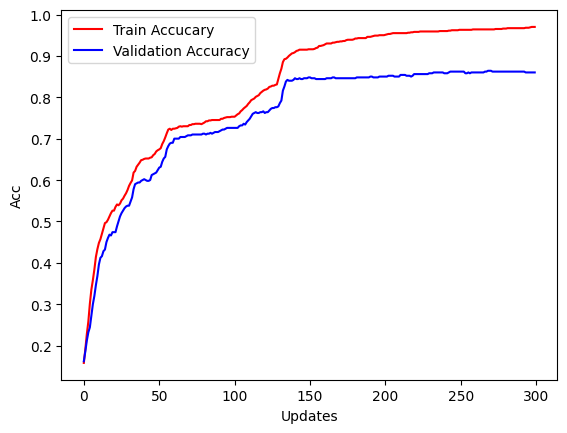

In [28]:
# we could have done this ourselves,
# but we should be aware of sklearn and its tools
from sklearn.metrics import accuracy_score


# setting hyperparameters and gettings epoch sizes
batch_size = 100
num_epochs = 300
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        # compute gradients given loss
        target_batch = targets_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        preds = torch.max(output, 1)[1]
        
        train_targs += list(targets_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(x_valid[slce])
        preds = torch.max(output, 1)[1]
        val_targs += list(targets_valid[slce].numpy())
        val_preds += list(preds.data.numpy())
        

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')

Combining an extra layer, ReLU activation and Adam optimizer achieves a fairly high accuracy of 0.862 compared to the original network and other networks. This is the highest achieved yet. 

I theorize that a mixture of additional layers, different activation function and using Adam for optimization can increase the maximum achievable accuracy. However I am not going to delve deeper into it for now.  

## Conclusion of Neural Network Investigations

Based on the experiments, I can summarize the results of my investigation as follows:

1. **Kaiming He Initialization vs. Xavier Glorot:**
   - Kaiming He initialization achieved a validation accuracy of **0.766** compared to Xavier Glorot’s **0.788**.
   - **Key Conclusion:** The difference between the two initializations is minor, making it difficult to determine a clear advantage of one over the other.

2. **Adding an Extra Layer:**
   - Adding an additional layer to the network initialized with Xavier resulted in a significant improvement in accuracy (from **0.788** to **0.848**).
   - The accuracy curve was still increasing at the end of training.
   - **Key Conclusion:** Additional layers improve the network’s performance, and further training could yield even better results.

3. **ReLU vs. ELU Activation:**
   - The change from ELU to ReLU resulted in similar validation accuracy.
   - **Key Conclusion:** Changing the activation function from ELU to ReLU does not significantly improve performance on its own.

4. **Adding Momentum:**
   - Introducing momentum sped up convergence, achieving a higher accuracy of **0.84**.
   - However, momentum didn’t seem to affect the maximum achievable accuracy.
   - **Key Conclusion:** Momentum improves learning speed but may not enhance the maximum performance.

5. **Adam Optimizer:**
   - Switching to the Adam optimizer (betas 0.9, 0.999) resulted in the highest accuracy of **0.85**.
   - The learning curve quickly saturated, indicating fast convergence.
   - **Key Conclusion:** Adam optimizer ensures fast convergence but may reach the network's maximum potential sooner.

6. **Combination of Extra Layer, ReLU, and Adam Optimizer:**
   - Combining these changes achieved a validation accuracy of **0.87**.
   - **Key Conclusion:** The combination of an extra layer, ReLU activation, and Adam optimization yielded the best overall performance.

### **Final Summary:**
While individual adjustments (e.g., optimizer, extra layers, activation functions) have varying effects, **the combination of an extra layer, ReLU activation, and the Adam optimizer led to the highest accuracy of 0.87**. These findings suggest that a balanced mix of changes can significantly enhance the network's performance, although further optimization could still be explored.

**Final Note:** All these investigations have been somewhat superficial, and there is potential for better results by further tweaking the individual networks and parameters. With more detailed exploration, such as fine-tuning hyperparameters or performing additional trials, the performance of the networks could likely be improved.


I then proceed with trying out regularization 

# Advanced assignments - Regularization 

In this section I will test out regularization on the following network:
Compared to the original network, this network has an added extra hidden layer with 512 hidden units, Relu activation instead of ELU and uses Adam optimization with a learning rate of 1e-5.


Reason I will use this instead of the standard network is that a deeper neural network with an extra layer has more tendency to overfit which is what regularization aims to mitigate. Furthermore Adam optimizer seemed to help it converge better and faster. 

Finally I let it train for 800 epoch to let it saturate the learning curve

I run it a bit more epochs to let the learning curve saturate and thus the following will be my benchmark

In [49]:
#Hyperparameters
num_classes = 10
num_l1 = 512
num_l2 = 512
num_features = x_train.shape[1]

# define network
class Net(nn.Module):

    def __init__(self, num_features, num_hidden1,num_hidden2, num_output):
        super(Net, self).__init__()  
        # input layer
        self.W_1 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden1, num_features)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden1), 0))
        # hidden layer
        self.W_2 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden2, num_hidden1)))
        self.b_2 = Parameter(init.constant_(torch.Tensor(num_hidden2), 0))

        # Another hidden layer
        self.W_3 = Parameter(init.xavier_normal_(torch.Tensor(num_output, num_hidden2)))
        self.b_3 = Parameter(init.constant_(torch.Tensor(num_output), 0))


        # define activation function in constructor
        self.activation = torch.nn.ReLU()

    def forward(self, x):
        x = F.linear(x, self.W_1, self.b_1)
        x = self.activation(x)
        x = F.linear(x, self.W_2, self.b_2)
        x = self.activation(x) # added another activation function
        x = F.linear(x, self.W_3, self.b_3) # added another layer
        
        x = F.softmax(x, dim=1)
        return x


net = Net(num_features, num_l1,num_l2, num_classes)

optimizer = optim.Adam(net.parameters(), lr=1e-5,betas = (0.9, 0.999))
criterion = nn.CrossEntropyLoss()



Epoch  1 : Train Loss 0.230062 , Train acc 0.130000, Valid acc 0.138000
Epoch 11 : Train Loss 0.226146 , Train acc 0.409000, Valid acc 0.388000
Epoch 21 : Train Loss 0.218645 , Train acc 0.509000, Valid acc 0.468000
Epoch 31 : Train Loss 0.207820 , Train acc 0.620000, Valid acc 0.548000
Epoch 41 : Train Loss 0.194688 , Train acc 0.742000, Valid acc 0.710000
Epoch 51 : Train Loss 0.184439 , Train acc 0.780000, Valid acc 0.746000
Epoch 61 : Train Loss 0.178383 , Train acc 0.790000, Valid acc 0.752000
Epoch 71 : Train Loss 0.174502 , Train acc 0.805000, Valid acc 0.770000
Epoch 81 : Train Loss 0.171434 , Train acc 0.833000, Valid acc 0.790000
Epoch 91 : Train Loss 0.168116 , Train acc 0.875000, Valid acc 0.820000
Epoch 101 : Train Loss 0.165361 , Train acc 0.899000, Valid acc 0.842000
Epoch 111 : Train Loss 0.163197 , Train acc 0.914000, Valid acc 0.856000
Epoch 121 : Train Loss 0.161474 , Train acc 0.919000, Valid acc 0.852000
Epoch 131 : Train Loss 0.160072 , Train acc 0.926000, Valid a

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Acc'))

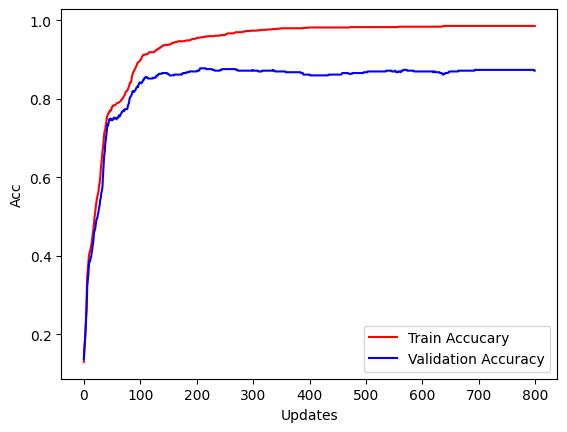

In [50]:
# we could have done this ourselves,
# but we should be aware of sklearn and its tools
from sklearn.metrics import accuracy_score


# setting hyperparameters and gettings epoch sizes
batch_size = 100
num_epochs = 800
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        # compute gradients given loss
        target_batch = targets_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        preds = torch.max(output, 1)[1]
        
        train_targs += list(targets_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(x_valid[slce])
        preds = torch.max(output, 1)[1]
        val_targs += list(targets_valid[slce].numpy())
        val_preds += list(preds.data.numpy())
        

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')

My benchmark network with Adam optimizer, ReLU, an extra hidden layer and 800 epocs achieved a validation error of 0.874

I start by adding weight decay to the benchmark network. 

I first try with L2 regularization which can simply be implemented in the optimization function. I start with an 0.1 weight decay. 

In [51]:
#Hyperparameters
num_classes = 10
num_l1 = 512
num_l2 = 512
num_features = x_train.shape[1]

# define network
class Net(nn.Module):

    def __init__(self, num_features, num_hidden1,num_hidden2, num_output):
        super(Net, self).__init__()  
        # input layer
        self.W_1 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden1, num_features)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden1), 0))
        # hidden layer
        self.W_2 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden2, num_hidden1)))
        self.b_2 = Parameter(init.constant_(torch.Tensor(num_hidden2), 0))

        # Another hidden layer
        self.W_3 = Parameter(init.xavier_normal_(torch.Tensor(num_output, num_hidden2)))
        self.b_3 = Parameter(init.constant_(torch.Tensor(num_output), 0))


        # define activation function in constructor
        self.activation = torch.nn.ReLU()

    def forward(self, x):
        x = F.linear(x, self.W_1, self.b_1)
        x = self.activation(x)
        x = F.linear(x, self.W_2, self.b_2)
        x = self.activation(x) # added another activation function
        x = F.linear(x, self.W_3, self.b_3) # added another layer
        
        x = F.softmax(x, dim=1)
        return x


net = Net(num_features, num_l1,num_l2, num_classes)

optimizer = optim.Adam(net.parameters(), lr=1e-5,betas = (0.9, 0.999), weight_decay=0.1)
criterion = nn.CrossEntropyLoss()



Epoch  1 : Train Loss 0.230668 , Train acc 0.065000, Valid acc 0.058000
Epoch 11 : Train Loss 0.230495 , Train acc 0.072000, Valid acc 0.064000
Epoch 21 : Train Loss 0.230340 , Train acc 0.084000, Valid acc 0.070000
Epoch 31 : Train Loss 0.230203 , Train acc 0.107000, Valid acc 0.080000
Epoch 41 : Train Loss 0.230080 , Train acc 0.125000, Valid acc 0.096000
Epoch 51 : Train Loss 0.229970 , Train acc 0.144000, Valid acc 0.128000
Epoch 61 : Train Loss 0.229872 , Train acc 0.164000, Valid acc 0.144000
Epoch 71 : Train Loss 0.229787 , Train acc 0.179000, Valid acc 0.166000
Epoch 81 : Train Loss 0.229711 , Train acc 0.192000, Valid acc 0.180000
Epoch 91 : Train Loss 0.229646 , Train acc 0.207000, Valid acc 0.194000
Epoch 101 : Train Loss 0.229591 , Train acc 0.221000, Valid acc 0.204000
Epoch 111 : Train Loss 0.229544 , Train acc 0.241000, Valid acc 0.208000
Epoch 121 : Train Loss 0.229505 , Train acc 0.258000, Valid acc 0.218000
Epoch 131 : Train Loss 0.229474 , Train acc 0.269000, Valid a

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Acc'))

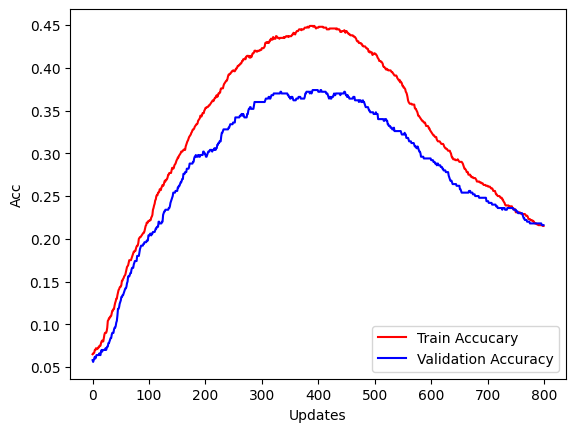

In [52]:
# we could have done this ourselves,
# but we should be aware of sklearn and its tools
from sklearn.metrics import accuracy_score


# setting hyperparameters and gettings epoch sizes
batch_size = 100
num_epochs = 800
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        # compute gradients given loss
        target_batch = targets_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        preds = torch.max(output, 1)[1]
        
        train_targs += list(targets_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(x_valid[slce])
        preds = torch.max(output, 1)[1]
        val_targs += list(targets_valid[slce].numpy())
        val_preds += list(preds.data.numpy())
        

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')

Having a L2 weight decay rate of 0.1 seems way to aggressive of a weight decay rate as it was unable to converge at all and has its highest validation accuracy of 0.45 

Thus I try 0.01:

In [53]:
#Hyperparameters
num_classes = 10
num_l1 = 512
num_l2 = 512
num_features = x_train.shape[1]

# define network
class Net(nn.Module):

    def __init__(self, num_features, num_hidden1,num_hidden2, num_output):
        super(Net, self).__init__()  
        # input layer
        self.W_1 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden1, num_features)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden1), 0))
        # hidden layer
        self.W_2 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden2, num_hidden1)))
        self.b_2 = Parameter(init.constant_(torch.Tensor(num_hidden2), 0))

        # Another hidden layer
        self.W_3 = Parameter(init.xavier_normal_(torch.Tensor(num_output, num_hidden2)))
        self.b_3 = Parameter(init.constant_(torch.Tensor(num_output), 0))


        # define activation function in constructor
        self.activation = torch.nn.ReLU()

    def forward(self, x):
        x = F.linear(x, self.W_1, self.b_1)
        x = self.activation(x)
        x = F.linear(x, self.W_2, self.b_2)
        x = self.activation(x) # added another activation function
        x = F.linear(x, self.W_3, self.b_3) # added another layer
        
        x = F.softmax(x, dim=1)
        return x


net = Net(num_features, num_l1,num_l2, num_classes)

optimizer = optim.Adam(net.parameters(), lr=1e-5,betas = (0.9, 0.999), weight_decay=0.01)
criterion = nn.CrossEntropyLoss()



Epoch  1 : Train Loss 0.230197 , Train acc 0.086000, Valid acc 0.104000
Epoch 11 : Train Loss 0.228817 , Train acc 0.319000, Valid acc 0.290000
Epoch 21 : Train Loss 0.226750 , Train acc 0.452000, Valid acc 0.398000
Epoch 31 : Train Loss 0.223024 , Train acc 0.448000, Valid acc 0.370000
Epoch 41 : Train Loss 0.217094 , Train acc 0.497000, Valid acc 0.408000
Epoch 51 : Train Loss 0.210323 , Train acc 0.579000, Valid acc 0.526000
Epoch 61 : Train Loss 0.203350 , Train acc 0.613000, Valid acc 0.606000
Epoch 71 : Train Loss 0.197442 , Train acc 0.631000, Valid acc 0.614000
Epoch 81 : Train Loss 0.193216 , Train acc 0.641000, Valid acc 0.620000
Epoch 91 : Train Loss 0.189903 , Train acc 0.672000, Valid acc 0.626000
Epoch 101 : Train Loss 0.186612 , Train acc 0.705000, Valid acc 0.680000
Epoch 111 : Train Loss 0.183486 , Train acc 0.750000, Valid acc 0.726000
Epoch 121 : Train Loss 0.180760 , Train acc 0.768000, Valid acc 0.740000
Epoch 131 : Train Loss 0.178655 , Train acc 0.776000, Valid a

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Acc'))

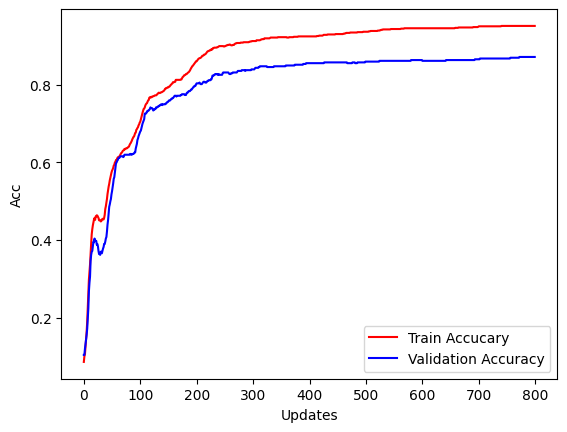

In [54]:
# we could have done this ourselves,
# but we should be aware of sklearn and its tools
from sklearn.metrics import accuracy_score


# setting hyperparameters and gettings epoch sizes
batch_size = 100
num_epochs = 800
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        # compute gradients given loss
        target_batch = targets_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        preds = torch.max(output, 1)[1]
        
        train_targs += list(targets_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(x_valid[slce])
        preds = torch.max(output, 1)[1]
        val_targs += list(targets_valid[slce].numpy())
        val_preds += list(preds.data.numpy())
        

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')

0.01 L2 weight decay still seems a bit too aggresive as it achives a validation accuracy of 0.872 which is good but it takes many epochs to reach that accuracy. 

I try 0.001

In [55]:
#Hyperparameters
num_classes = 10
num_l1 = 512
num_l2 = 512
num_features = x_train.shape[1]

# define network
class Net(nn.Module):

    def __init__(self, num_features, num_hidden1,num_hidden2, num_output):
        super(Net, self).__init__()  
        # input layer
        self.W_1 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden1, num_features)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden1), 0))
        # hidden layer
        self.W_2 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden2, num_hidden1)))
        self.b_2 = Parameter(init.constant_(torch.Tensor(num_hidden2), 0))

        # Another hidden layer
        self.W_3 = Parameter(init.xavier_normal_(torch.Tensor(num_output, num_hidden2)))
        self.b_3 = Parameter(init.constant_(torch.Tensor(num_output), 0))


        # define activation function in constructor
        self.activation = torch.nn.ReLU()

    def forward(self, x):
        x = F.linear(x, self.W_1, self.b_1)
        x = self.activation(x)
        x = F.linear(x, self.W_2, self.b_2)
        x = self.activation(x) # added another activation function
        x = F.linear(x, self.W_3, self.b_3) # added another layer
        
        x = F.softmax(x, dim=1)
        return x


net = Net(num_features, num_l1,num_l2, num_classes)

optimizer = optim.Adam(net.parameters(), lr=1e-5,betas = (0.9, 0.999), weight_decay=0.001)
criterion = nn.CrossEntropyLoss()



Epoch  1 : Train Loss 0.229898 , Train acc 0.155000, Valid acc 0.156000
Epoch 11 : Train Loss 0.225808 , Train acc 0.406000, Valid acc 0.362000
Epoch 21 : Train Loss 0.218462 , Train acc 0.485000, Valid acc 0.456000
Epoch 31 : Train Loss 0.208662 , Train acc 0.519000, Valid acc 0.490000
Epoch 41 : Train Loss 0.199660 , Train acc 0.576000, Valid acc 0.548000
Epoch 51 : Train Loss 0.190919 , Train acc 0.708000, Valid acc 0.670000
Epoch 61 : Train Loss 0.184333 , Train acc 0.738000, Valid acc 0.690000
Epoch 71 : Train Loss 0.180399 , Train acc 0.747000, Valid acc 0.704000
Epoch 81 : Train Loss 0.177696 , Train acc 0.753000, Valid acc 0.706000
Epoch 91 : Train Loss 0.174671 , Train acc 0.798000, Valid acc 0.736000
Epoch 101 : Train Loss 0.170189 , Train acc 0.866000, Valid acc 0.798000
Epoch 111 : Train Loss 0.167038 , Train acc 0.892000, Valid acc 0.820000
Epoch 121 : Train Loss 0.164710 , Train acc 0.906000, Valid acc 0.824000
Epoch 131 : Train Loss 0.162888 , Train acc 0.912000, Valid a

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Acc'))

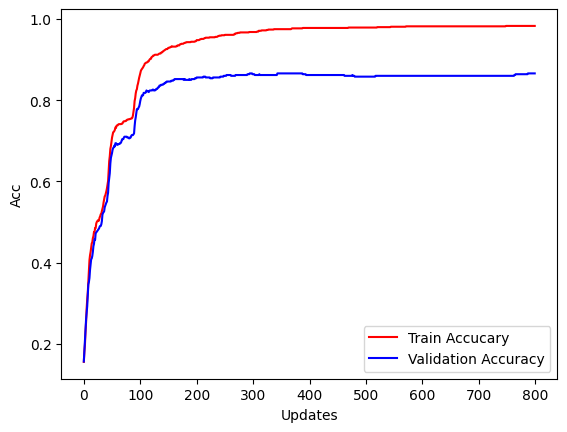

In [56]:
# we could have done this ourselves,
# but we should be aware of sklearn and its tools
from sklearn.metrics import accuracy_score


# setting hyperparameters and gettings epoch sizes
batch_size = 100
num_epochs = 800
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        # compute gradients given loss
        target_batch = targets_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        preds = torch.max(output, 1)[1]
        
        train_targs += list(targets_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(x_valid[slce])
        preds = torch.max(output, 1)[1]
        val_targs += list(targets_valid[slce].numpy())
        val_preds += list(preds.data.numpy())
        

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')

For L2 weight decay of 0.001 I see comparable results as for 0.01. However it achieves saturation of learning curve faster. 

I try a bit lower weight decay again of 0.0001

In [57]:
#Hyperparameters
num_classes = 10
num_l1 = 512
num_l2 = 512
num_features = x_train.shape[1]

# define network
class Net(nn.Module):

    def __init__(self, num_features, num_hidden1,num_hidden2, num_output):
        super(Net, self).__init__()  
        # input layer
        self.W_1 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden1, num_features)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden1), 0))
        # hidden layer
        self.W_2 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden2, num_hidden1)))
        self.b_2 = Parameter(init.constant_(torch.Tensor(num_hidden2), 0))

        # Another hidden layer
        self.W_3 = Parameter(init.xavier_normal_(torch.Tensor(num_output, num_hidden2)))
        self.b_3 = Parameter(init.constant_(torch.Tensor(num_output), 0))


        # define activation function in constructor
        self.activation = torch.nn.ReLU()

    def forward(self, x):
        x = F.linear(x, self.W_1, self.b_1)
        x = self.activation(x)
        x = F.linear(x, self.W_2, self.b_2)
        x = self.activation(x) # added another activation function
        x = F.linear(x, self.W_3, self.b_3) # added another layer
        
        x = F.softmax(x, dim=1)
        return x


net = Net(num_features, num_l1,num_l2, num_classes)

optimizer = optim.Adam(net.parameters(), lr=1e-5,betas = (0.9, 0.999), weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()



Epoch  1 : Train Loss 0.230260 , Train acc 0.088000, Valid acc 0.070000
Epoch 11 : Train Loss 0.226052 , Train acc 0.341000, Valid acc 0.314000
Epoch 21 : Train Loss 0.218414 , Train acc 0.425000, Valid acc 0.382000
Epoch 31 : Train Loss 0.208878 , Train acc 0.483000, Valid acc 0.422000
Epoch 41 : Train Loss 0.199532 , Train acc 0.658000, Valid acc 0.610000
Epoch 51 : Train Loss 0.189980 , Train acc 0.697000, Valid acc 0.670000
Epoch 61 : Train Loss 0.183660 , Train acc 0.709000, Valid acc 0.682000
Epoch 71 : Train Loss 0.178326 , Train acc 0.790000, Valid acc 0.740000
Epoch 81 : Train Loss 0.173339 , Train acc 0.849000, Valid acc 0.790000
Epoch 91 : Train Loss 0.169781 , Train acc 0.862000, Valid acc 0.802000
Epoch 101 : Train Loss 0.167079 , Train acc 0.877000, Valid acc 0.816000
Epoch 111 : Train Loss 0.164916 , Train acc 0.889000, Valid acc 0.820000
Epoch 121 : Train Loss 0.163130 , Train acc 0.897000, Valid acc 0.828000
Epoch 131 : Train Loss 0.161612 , Train acc 0.906000, Valid a

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Acc'))

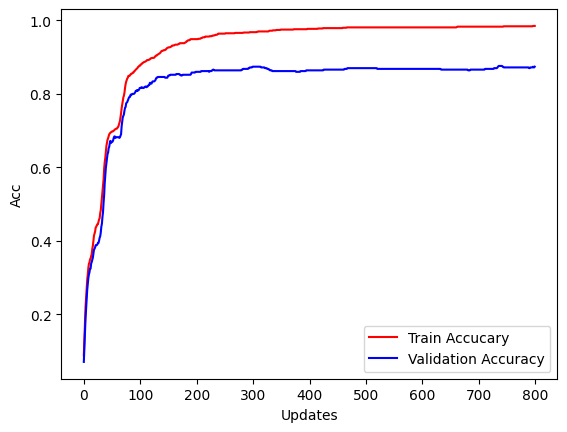

In [58]:
# we could have done this ourselves,
# but we should be aware of sklearn and its tools
from sklearn.metrics import accuracy_score


# setting hyperparameters and gettings epoch sizes
batch_size = 100
num_epochs = 800
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        # compute gradients given loss
        target_batch = targets_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        preds = torch.max(output, 1)[1]
        
        train_targs += list(targets_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(x_valid[slce])
        preds = torch.max(output, 1)[1]
        val_targs += list(targets_valid[slce].numpy())
        val_preds += list(preds.data.numpy())
        

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')

This seems to be the best achievable validation accuracy around 0.872 with 0.0001 weight decay. However it is only on the same level of accuracy as the benchmark network. Thus I must conclude that it does not look like L2 regularization helps this network for this problem.

I proceed to test out L1 regularization 
### L1 Regularization

L1 Regularization needs to be implemented in the training loop  

I start by trying 1e-4 L1 regularization

In [11]:
#Hyperparameters
num_classes = 10
num_l1 = 512
num_l2 = 512
num_features = x_train.shape[1]

# define network
class Net(nn.Module):

    def __init__(self, num_features, num_hidden1,num_hidden2, num_output):
        super(Net, self).__init__()  
        # input layer
        self.W_1 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden1, num_features)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden1), 0))
        # hidden layer
        self.W_2 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden2, num_hidden1)))
        self.b_2 = Parameter(init.constant_(torch.Tensor(num_hidden2), 0))

        # Another hidden layer
        self.W_3 = Parameter(init.xavier_normal_(torch.Tensor(num_output, num_hidden2)))
        self.b_3 = Parameter(init.constant_(torch.Tensor(num_output), 0))


        # define activation function in constructor
        self.activation = torch.nn.ReLU()

    def forward(self, x):
        x = F.linear(x, self.W_1, self.b_1)
        x = self.activation(x)
        x = F.linear(x, self.W_2, self.b_2)
        x = self.activation(x) # added another activation function
        x = F.linear(x, self.W_3, self.b_3) # added another layer
        
        x = F.softmax(x, dim=1)
        return x


net = Net(num_features, num_l1,num_l2, num_classes)

optimizer = optim.Adam(net.parameters(), lr=1e-5,betas = (0.9, 0.999))
criterion = nn.CrossEntropyLoss()



Epoch  1 : Train Loss 0.450790 , Train acc 0.088000, Valid acc 0.082000
Epoch 11 : Train Loss 0.443417 , Train acc 0.381000, Valid acc 0.330000
Epoch 21 : Train Loss 0.434222 , Train acc 0.510000, Valid acc 0.468000
Epoch 31 : Train Loss 0.421219 , Train acc 0.516000, Valid acc 0.480000
Epoch 41 : Train Loss 0.408073 , Train acc 0.561000, Valid acc 0.514000
Epoch 51 : Train Loss 0.396526 , Train acc 0.662000, Valid acc 0.602000
Epoch 61 : Train Loss 0.385534 , Train acc 0.746000, Valid acc 0.700000
Epoch 71 : Train Loss 0.376230 , Train acc 0.775000, Valid acc 0.738000
Epoch 81 : Train Loss 0.368782 , Train acc 0.793000, Valid acc 0.742000
Epoch 91 : Train Loss 0.362585 , Train acc 0.801000, Valid acc 0.760000
Epoch 101 : Train Loss 0.357064 , Train acc 0.808000, Valid acc 0.762000
Epoch 111 : Train Loss 0.351393 , Train acc 0.857000, Valid acc 0.782000
Epoch 121 : Train Loss 0.345996 , Train acc 0.887000, Valid acc 0.812000
Epoch 131 : Train Loss 0.341173 , Train acc 0.898000, Valid a

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Acc'))

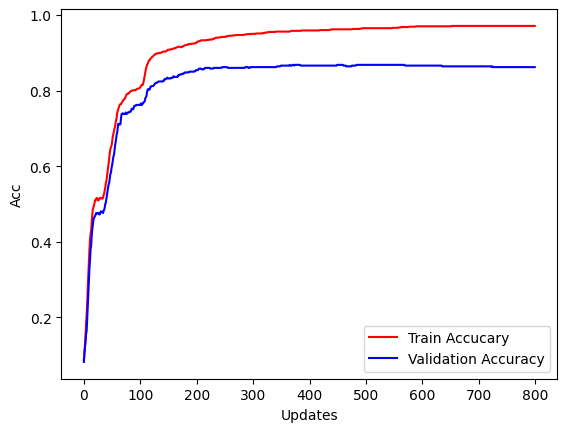

In [12]:
# we could have done this ourselves,
# but we should be aware of sklearn and its tools
from sklearn.metrics import accuracy_score


# setting hyperparameters and gettings epoch sizes
batch_size = 100
num_epochs = 800
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

# L1 regularization 
l1_lambda = 1e-4

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        # compute gradients given loss
        target_batch = targets_train[slce]
        batch_loss = criterion(output, target_batch)
        
        # L1 regularization
        l1_reg = 0
        for param in net.parameters():
            l1_reg += torch.sum(torch.abs(param))
        batch_loss += l1_lambda * l1_reg
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        preds = torch.max(output, 1)[1]
        
        train_targs += list(targets_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(x_valid[slce])
        preds = torch.max(output, 1)[1]
        val_targs += list(targets_valid[slce].numpy())
        val_preds += list(preds.data.numpy())
        

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')

L1 regularization with a regularzation parameter of 1e-4 seems to work fairly well with a validation accuracy of 0.862. However it is still worse than the benchmark. I try a more modest regularization of 1e-6

In [13]:
#Hyperparameters
num_classes = 10
num_l1 = 512
num_l2 = 512
num_features = x_train.shape[1]

# define network
class Net(nn.Module):

    def __init__(self, num_features, num_hidden1,num_hidden2, num_output):
        super(Net, self).__init__()  
        # input layer
        self.W_1 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden1, num_features)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden1), 0))
        # hidden layer
        self.W_2 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden2, num_hidden1)))
        self.b_2 = Parameter(init.constant_(torch.Tensor(num_hidden2), 0))

        # Another hidden layer
        self.W_3 = Parameter(init.xavier_normal_(torch.Tensor(num_output, num_hidden2)))
        self.b_3 = Parameter(init.constant_(torch.Tensor(num_output), 0))


        # define activation function in constructor
        self.activation = torch.nn.ReLU()

    def forward(self, x):
        x = F.linear(x, self.W_1, self.b_1)
        x = self.activation(x)
        x = F.linear(x, self.W_2, self.b_2)
        x = self.activation(x) # added another activation function
        x = F.linear(x, self.W_3, self.b_3) # added another layer
        
        x = F.softmax(x, dim=1)
        return x


net = Net(num_features, num_l1,num_l2, num_classes)

optimizer = optim.Adam(net.parameters(), lr=1e-5,betas = (0.9, 0.999))
criterion = nn.CrossEntropyLoss()



Epoch  1 : Train Loss 0.232498 , Train acc 0.117000, Valid acc 0.120000
Epoch 11 : Train Loss 0.229084 , Train acc 0.304000, Valid acc 0.268000
Epoch 21 : Train Loss 0.222546 , Train acc 0.492000, Valid acc 0.442000
Epoch 31 : Train Loss 0.211910 , Train acc 0.635000, Valid acc 0.574000
Epoch 41 : Train Loss 0.199198 , Train acc 0.723000, Valid acc 0.668000
Epoch 51 : Train Loss 0.188897 , Train acc 0.771000, Valid acc 0.728000
Epoch 61 : Train Loss 0.182076 , Train acc 0.789000, Valid acc 0.742000
Epoch 71 : Train Loss 0.177618 , Train acc 0.808000, Valid acc 0.760000
Epoch 81 : Train Loss 0.173881 , Train acc 0.853000, Valid acc 0.784000
Epoch 91 : Train Loss 0.170657 , Train acc 0.877000, Valid acc 0.814000
Epoch 101 : Train Loss 0.168055 , Train acc 0.895000, Valid acc 0.834000
Epoch 111 : Train Loss 0.165952 , Train acc 0.906000, Valid acc 0.838000
Epoch 121 : Train Loss 0.164236 , Train acc 0.915000, Valid acc 0.844000
Epoch 131 : Train Loss 0.162803 , Train acc 0.918000, Valid a

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Acc'))

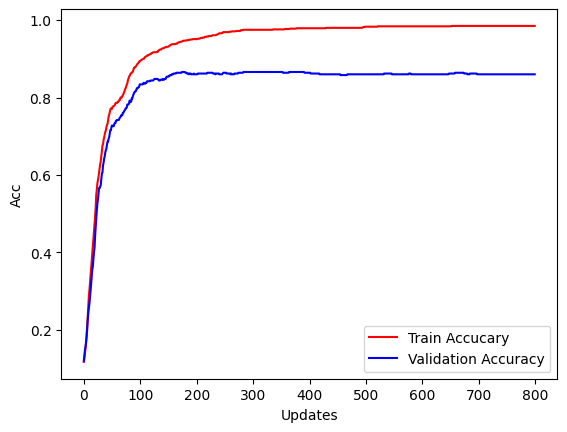

In [14]:
# we could have done this ourselves,
# but we should be aware of sklearn and its tools
from sklearn.metrics import accuracy_score


# setting hyperparameters and gettings epoch sizes
batch_size = 100
num_epochs = 800
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

# L1 regularization 
l1_lambda = 1e-6

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        # compute gradients given loss
        target_batch = targets_train[slce]
        batch_loss = criterion(output, target_batch)
        
        # L1 regularization
        l1_reg = 0
        for param in net.parameters():
            l1_reg += torch.sum(torch.abs(param))
        batch_loss += l1_lambda * l1_reg
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        preds = torch.max(output, 1)[1]
        
        train_targs += list(targets_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(x_valid[slce])
        preds = torch.max(output, 1)[1]
        val_targs += list(targets_valid[slce].numpy())
        val_preds += list(preds.data.numpy())
        

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')

A regularization parameter of 1e-6. That did not seem to help it that much. It shows sign of saturating the learning curve and has a validation accuracy of 0.86 which is slightly lower than the benchmark. I give it a final try with 1e-8 L1 regularization

In [15]:
#Hyperparameters
num_classes = 10
num_l1 = 512
num_l2 = 512
num_features = x_train.shape[1]

# define network
class Net(nn.Module):

    def __init__(self, num_features, num_hidden1,num_hidden2, num_output):
        super(Net, self).__init__()  
        # input layer
        self.W_1 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden1, num_features)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden1), 0))
        # hidden layer
        self.W_2 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden2, num_hidden1)))
        self.b_2 = Parameter(init.constant_(torch.Tensor(num_hidden2), 0))

        # Another hidden layer
        self.W_3 = Parameter(init.xavier_normal_(torch.Tensor(num_output, num_hidden2)))
        self.b_3 = Parameter(init.constant_(torch.Tensor(num_output), 0))


        # define activation function in constructor
        self.activation = torch.nn.ReLU()

    def forward(self, x):
        x = F.linear(x, self.W_1, self.b_1)
        x = self.activation(x)
        x = F.linear(x, self.W_2, self.b_2)
        x = self.activation(x) # added another activation function
        x = F.linear(x, self.W_3, self.b_3) # added another layer
        
        x = F.softmax(x, dim=1)
        return x


net = Net(num_features, num_l1,num_l2, num_classes)

optimizer = optim.Adam(net.parameters(), lr=1e-5,betas = (0.9, 0.999))
criterion = nn.CrossEntropyLoss()



Epoch  1 : Train Loss 0.230388 , Train acc 0.101000, Valid acc 0.110000
Epoch 11 : Train Loss 0.226987 , Train acc 0.445000, Valid acc 0.394000
Epoch 21 : Train Loss 0.220291 , Train acc 0.551000, Valid acc 0.506000
Epoch 31 : Train Loss 0.209450 , Train acc 0.635000, Valid acc 0.596000
Epoch 41 : Train Loss 0.197678 , Train acc 0.688000, Valid acc 0.638000
Epoch 51 : Train Loss 0.187877 , Train acc 0.762000, Valid acc 0.710000
Epoch 61 : Train Loss 0.180182 , Train acc 0.806000, Valid acc 0.740000
Epoch 71 : Train Loss 0.174501 , Train acc 0.849000, Valid acc 0.784000
Epoch 81 : Train Loss 0.170436 , Train acc 0.881000, Valid acc 0.802000
Epoch 91 : Train Loss 0.167418 , Train acc 0.896000, Valid acc 0.818000
Epoch 101 : Train Loss 0.165065 , Train acc 0.905000, Valid acc 0.832000
Epoch 111 : Train Loss 0.163164 , Train acc 0.914000, Valid acc 0.838000
Epoch 121 : Train Loss 0.161589 , Train acc 0.920000, Valid acc 0.850000
Epoch 131 : Train Loss 0.160257 , Train acc 0.921000, Valid a

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Acc'))

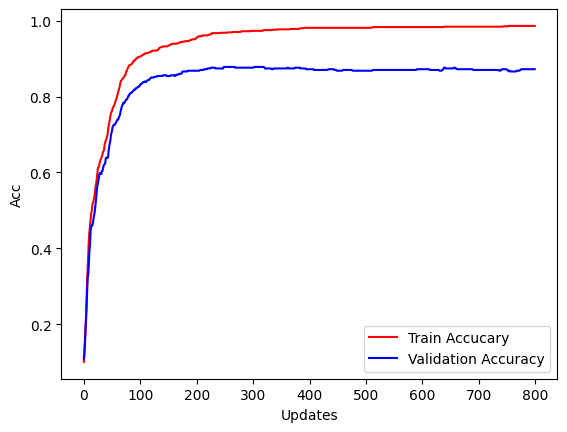

In [16]:
# we could have done this ourselves,
# but we should be aware of sklearn and its tools
from sklearn.metrics import accuracy_score


# setting hyperparameters and gettings epoch sizes
batch_size = 100
num_epochs = 800
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

# L1 regularization 
l1_lambda = 1e-8

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        # compute gradients given loss
        target_batch = targets_train[slce]
        batch_loss = criterion(output, target_batch)
        
        # L1 regularization
        l1_reg = 0
        for param in net.parameters():
            l1_reg += torch.sum(torch.abs(param))
        batch_loss += l1_lambda * l1_reg
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        preds = torch.max(output, 1)[1]
        
        train_targs += list(targets_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(x_valid[slce])
        preds = torch.max(output, 1)[1]
        val_targs += list(targets_valid[slce].numpy())
        val_preds += list(preds.data.numpy())
        

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')

A L1 regularization of 1e-8 gives approximately the same validation accuracy as the benchmark model. I conclude that L1 regularization does not help in this case. Maybe If I had a more complex model then it could help negating overfitting. 

I then go to tryout dropout regularization
### Dropout regularization

To add Dropout regularization I add a dropout layer to the network class and dropout in the forward method

I start with a dropout probability of 0.5

In [17]:
#Hyperparameters
num_classes = 10
num_l1 = 512
num_l2 = 512
num_features = x_train.shape[1]

# define network
class Net(nn.Module):

    def __init__(self, num_features, num_hidden1,num_hidden2, num_output,dropout_prob):
        super(Net, self).__init__()  
        # input layer
        self.W_1 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden1, num_features)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden1), 0))
        # hidden layer
        self.W_2 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden2, num_hidden1)))
        self.b_2 = Parameter(init.constant_(torch.Tensor(num_hidden2), 0))

        # Another hidden layer
        self.W_3 = Parameter(init.xavier_normal_(torch.Tensor(num_output, num_hidden2)))
        self.b_3 = Parameter(init.constant_(torch.Tensor(num_output), 0))

        # define activation function in constructor
        self.activation = torch.nn.ReLU()
        
        # Dropout
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        x = F.linear(x, self.W_1, self.b_1)
        x = self.activation(x)
        x = self.dropout(x) # apply dropout
        
        x = F.linear(x, self.W_2, self.b_2)
        x = self.activation(x) # added another activation function
        x = self.dropout(x)# apply dropout
        
        x = F.linear(x, self.W_3, self.b_3) # added another layer
        
        x = F.softmax(x, dim=1)
        return x

dropout_prob = 0.5
net = Net(num_features, num_l1,num_l2, num_classes,dropout_prob)

optimizer = optim.Adam(net.parameters(), lr=1e-5,betas = (0.9, 0.999))
criterion = nn.CrossEntropyLoss()




Epoch  1 : Train Loss 0.229769 , Train acc 0.149000, Valid acc 0.142000
Epoch 11 : Train Loss 0.228468 , Train acc 0.394000, Valid acc 0.356000
Epoch 21 : Train Loss 0.225974 , Train acc 0.468000, Valid acc 0.410000
Epoch 31 : Train Loss 0.222226 , Train acc 0.457000, Valid acc 0.400000
Epoch 41 : Train Loss 0.216712 , Train acc 0.478000, Valid acc 0.426000
Epoch 51 : Train Loss 0.210944 , Train acc 0.514000, Valid acc 0.476000
Epoch 61 : Train Loss 0.205821 , Train acc 0.544000, Valid acc 0.514000
Epoch 71 : Train Loss 0.201357 , Train acc 0.604000, Valid acc 0.566000
Epoch 81 : Train Loss 0.197817 , Train acc 0.664000, Valid acc 0.616000
Epoch 91 : Train Loss 0.192717 , Train acc 0.693000, Valid acc 0.650000
Epoch 101 : Train Loss 0.189893 , Train acc 0.708000, Valid acc 0.662000
Epoch 111 : Train Loss 0.186858 , Train acc 0.712000, Valid acc 0.660000
Epoch 121 : Train Loss 0.184847 , Train acc 0.725000, Valid acc 0.672000
Epoch 131 : Train Loss 0.184313 , Train acc 0.730000, Valid a

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Acc'))

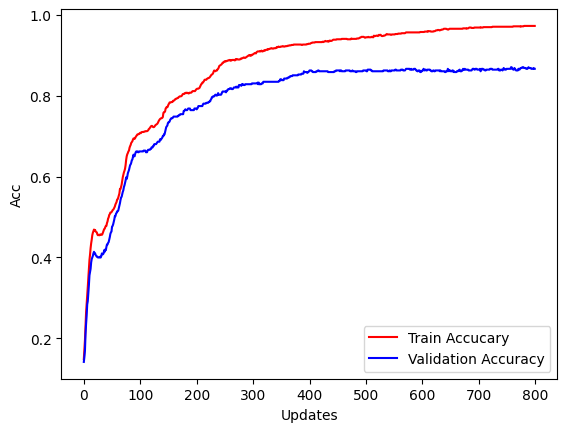

In [18]:
# we could have done this ourselves,
# but we should be aware of sklearn and its tools
from sklearn.metrics import accuracy_score


# setting hyperparameters and gettings epoch sizes
batch_size = 100
num_epochs = 800
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        # compute gradients given loss
        target_batch = targets_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        preds = torch.max(output, 1)[1]
        
        train_targs += list(targets_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(x_valid[slce])
        preds = torch.max(output, 1)[1]
        val_targs += list(targets_valid[slce].numpy())
        val_preds += list(preds.data.numpy())
        

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')

With a dropout rate of 0.5 we get a validation accuracy of 0.86. It seem from the learnnjg curve that this dropout rate is too high since it takes a while for the network to saturate the learning curve. 

I will try a learning rate of 0.1 now

In [29]:
#Hyperparameters
num_classes = 10
num_l1 = 512
num_l2 = 512
num_features = x_train.shape[1]

# define network
class Net(nn.Module):

    def __init__(self, num_features, num_hidden1,num_hidden2, num_output,dropout_prob):
        super(Net, self).__init__()  
        # input layer
        self.W_1 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden1, num_features)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden1), 0))
        # hidden layer
        self.W_2 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden2, num_hidden1)))
        self.b_2 = Parameter(init.constant_(torch.Tensor(num_hidden2), 0))

        # Another hidden layer
        self.W_3 = Parameter(init.xavier_normal_(torch.Tensor(num_output, num_hidden2)))
        self.b_3 = Parameter(init.constant_(torch.Tensor(num_output), 0))

        # define activation function in constructor
        self.activation = torch.nn.ReLU()
        
        # Dropout
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        x = F.linear(x, self.W_1, self.b_1)
        x = self.activation(x)
        x = self.dropout(x) # apply dropout
        
        x = F.linear(x, self.W_2, self.b_2)
        x = self.activation(x) # added another activation function
        x = self.dropout(x)# apply dropout
        
        x = F.linear(x, self.W_3, self.b_3) # added another layer
        
        x = F.softmax(x, dim=1)
        return x

dropout_prob = 0.1
net = Net(num_features, num_l1,num_l2, num_classes,dropout_prob)

optimizer = optim.Adam(net.parameters(), lr=1e-5,betas = (0.9, 0.999))
criterion = nn.CrossEntropyLoss()




Epoch  1 : Train Loss 0.229959 , Train acc 0.164000, Valid acc 0.180000
Epoch 11 : Train Loss 0.226276 , Train acc 0.587000, Valid acc 0.524000
Epoch 21 : Train Loss 0.219094 , Train acc 0.635000, Valid acc 0.578000
Epoch 31 : Train Loss 0.207820 , Train acc 0.648000, Valid acc 0.614000
Epoch 41 : Train Loss 0.196986 , Train acc 0.682000, Valid acc 0.650000
Epoch 51 : Train Loss 0.188799 , Train acc 0.712000, Valid acc 0.678000
Epoch 61 : Train Loss 0.182719 , Train acc 0.755000, Valid acc 0.720000
Epoch 71 : Train Loss 0.177692 , Train acc 0.800000, Valid acc 0.766000
Epoch 81 : Train Loss 0.174616 , Train acc 0.808000, Valid acc 0.774000
Epoch 91 : Train Loss 0.171870 , Train acc 0.820000, Valid acc 0.786000
Epoch 101 : Train Loss 0.170119 , Train acc 0.839000, Valid acc 0.798000
Epoch 111 : Train Loss 0.167184 , Train acc 0.885000, Valid acc 0.826000
Epoch 121 : Train Loss 0.165111 , Train acc 0.897000, Valid acc 0.836000
Epoch 131 : Train Loss 0.163600 , Train acc 0.910000, Valid a

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Acc'))

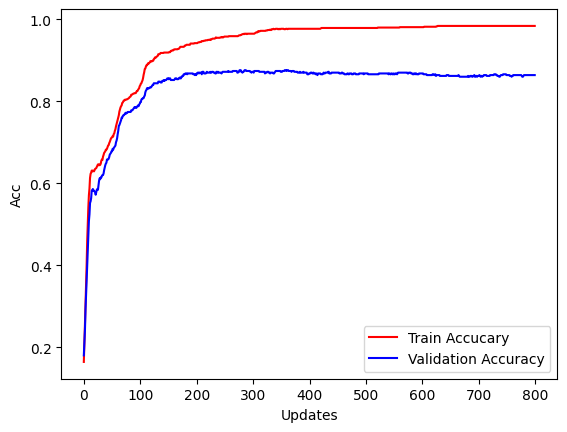

In [30]:
# we could have done this ourselves,
# but we should be aware of sklearn and its tools
from sklearn.metrics import accuracy_score


# setting hyperparameters and gettings epoch sizes
batch_size = 100
num_epochs = 800
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        # compute gradients given loss
        target_batch = targets_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        preds = torch.max(output, 1)[1]
        
        train_targs += list(targets_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(x_valid[slce])
        preds = torch.max(output, 1)[1]
        val_targs += list(targets_valid[slce].numpy())
        val_preds += list(preds.data.numpy())
        

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')

With a lower dropout probability of 0.1 the learning curve hits the 0.87 area faster but it stays around this validation accuracy indicating that dropout regularization does not help this network. 

Lastly I try the Batch normalization method:

### Batch normalization

Batch Normalization has to be added in the network structure and in the forward method. 

In [37]:
#Hyperparameters
num_classes = 10
num_l1 = 512
num_l2 = 512
num_features = x_train.shape[1]

# define network
class Net(nn.Module):

    def __init__(self, num_features, num_hidden1,num_hidden2, num_output):
        super(Net, self).__init__()  
        # input layer
        self.W_1 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden1, num_features)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden1), 0))
        
        # Batch normalization after the first layer
        self.batch_norm1 = nn.BatchNorm1d(num_hidden1)
        
        # hidden layer
        self.W_2 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden2, num_hidden1)))
        self.b_2 = Parameter(init.constant_(torch.Tensor(num_hidden2), 0))
        
        # Batch normalization after the second layer
        self.batch_norm2 = nn.BatchNorm1d(num_hidden2)

        # Another hidden layer
        self.W_3 = Parameter(init.xavier_normal_(torch.Tensor(num_output, num_hidden2)))
        self.b_3 = Parameter(init.constant_(torch.Tensor(num_output), 0))
        
        # Batch normalization after the third layer
        self.batch_norm3 = nn.BatchNorm1d(num_output)


        # define activation function in constructor
        self.activation = torch.nn.ReLU()

    def forward(self, x):
        x = F.linear(x, self.W_1, self.b_1)
        # apply batch normalization
        x = self.batch_norm1(x)
        x = self.activation(x)
        
        x = F.linear(x, self.W_2, self.b_2)
        # apply batch normalization
        x = self.batch_norm2(x)
        x = self.activation(x) # added another activation function
        x = F.linear(x, self.W_3, self.b_3) # added another layer
        # apply batch normalization
        x = self.batch_norm3(x)
        
        x = F.softmax(x, dim=1)
        return x


net = Net(num_features, num_l1,num_l2, num_classes)

optimizer = optim.Adam(net.parameters(), lr=1e-5,betas = (0.9, 0.999))
criterion = nn.CrossEntropyLoss()



Epoch  1 : Train Loss 0.231118 , Train acc 0.119000, Valid acc 0.138000
Epoch 11 : Train Loss 0.210469 , Train acc 0.543000, Valid acc 0.440000
Epoch 21 : Train Loss 0.197758 , Train acc 0.748000, Valid acc 0.674000
Epoch 31 : Train Loss 0.190430 , Train acc 0.840000, Valid acc 0.754000
Epoch 41 : Train Loss 0.186066 , Train acc 0.890000, Valid acc 0.784000
Epoch 51 : Train Loss 0.183129 , Train acc 0.908000, Valid acc 0.800000
Epoch 61 : Train Loss 0.180903 , Train acc 0.923000, Valid acc 0.810000
Epoch 71 : Train Loss 0.179103 , Train acc 0.944000, Valid acc 0.826000
Epoch 81 : Train Loss 0.177596 , Train acc 0.953000, Valid acc 0.828000
Epoch 91 : Train Loss 0.176300 , Train acc 0.962000, Valid acc 0.828000
Epoch 101 : Train Loss 0.175162 , Train acc 0.968000, Valid acc 0.832000
Epoch 111 : Train Loss 0.174150 , Train acc 0.978000, Valid acc 0.832000
Epoch 121 : Train Loss 0.173252 , Train acc 0.983000, Valid acc 0.832000
Epoch 131 : Train Loss 0.172461 , Train acc 0.990000, Valid a

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Acc'))

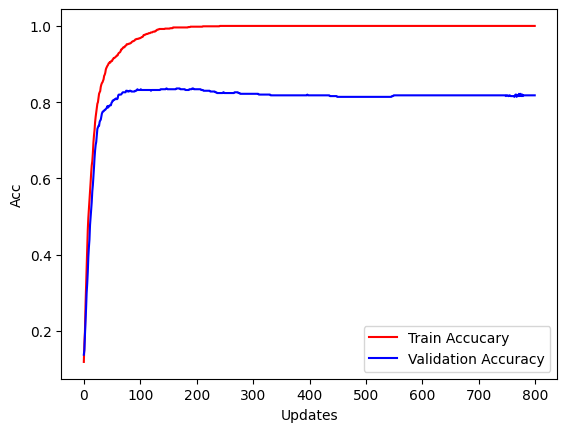

In [38]:

# we could have done this ourselves,
# but we should be aware of sklearn and its tools
from sklearn.metrics import accuracy_score


# setting hyperparameters and gettings epoch sizes
batch_size = 100
num_epochs = 800
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        # compute gradients given loss
        target_batch = targets_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        preds = torch.max(output, 1)[1]
        
        train_targs += list(targets_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(x_valid[slce])
        preds = torch.max(output, 1)[1]
        val_targs += list(targets_valid[slce].numpy())
        val_preds += list(preds.data.numpy())
        

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')

Batch normalization seems to hinder the learning in this instance resulting in a validation accuracy around 0.82. However reading up on the method it seems that it might benefit from a larger learning rate. 

Therefore I try again with 1e-4

In [41]:
net = Net(num_features, num_l1,num_l2, num_classes)
optimizer = optim.Adam(net.parameters(), lr=1e-4,betas = (0.9, 0.999))
criterion = nn.CrossEntropyLoss()



Epoch  1 : Train Loss 0.222160 , Train acc 0.484000, Valid acc 0.416000
Epoch 11 : Train Loss 0.176348 , Train acc 0.960000, Valid acc 0.828000
Epoch 21 : Train Loss 0.170097 , Train acc 0.995000, Valid acc 0.842000
Epoch 31 : Train Loss 0.167804 , Train acc 1.000000, Valid acc 0.840000
Epoch 41 : Train Loss 0.166745 , Train acc 1.000000, Valid acc 0.838000
Epoch 51 : Train Loss 0.166084 , Train acc 1.000000, Valid acc 0.840000
Epoch 61 : Train Loss 0.165548 , Train acc 1.000000, Valid acc 0.840000
Epoch 71 : Train Loss 0.165061 , Train acc 1.000000, Valid acc 0.838000
Epoch 81 : Train Loss 0.164600 , Train acc 1.000000, Valid acc 0.834000
Epoch 91 : Train Loss 0.164158 , Train acc 1.000000, Valid acc 0.834000
Epoch 101 : Train Loss 0.163737 , Train acc 1.000000, Valid acc 0.830000
Epoch 111 : Train Loss 0.163576 , Train acc 1.000000, Valid acc 0.848000
Epoch 121 : Train Loss 0.162978 , Train acc 1.000000, Valid acc 0.846000
Epoch 131 : Train Loss 0.162539 , Train acc 1.000000, Valid a

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Acc'))

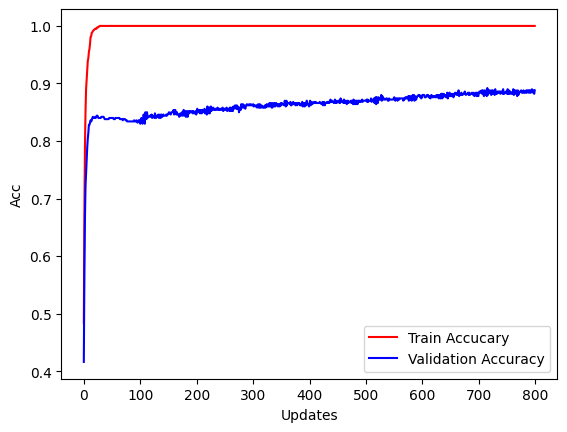

In [42]:

# we could have done this ourselves,
# but we should be aware of sklearn and its tools
from sklearn.metrics import accuracy_score


# setting hyperparameters and gettings epoch sizes
batch_size = 100
num_epochs = 800
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        # compute gradients given loss
        target_batch = targets_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        preds = torch.max(output, 1)[1]
        
        train_targs += list(targets_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(x_valid[slce])
        preds = torch.max(output, 1)[1]
        val_targs += list(targets_valid[slce].numpy())
        val_preds += list(preds.data.numpy())
        

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')

Batch normalization combined with a learning rate of 1e-4 seems to really have helped the validation accuracy as it increased the highest accuracy yet of 0.884. 

I will try one more time with a slightly higher learning rate of 2e-4

In [43]:
net = Net(num_features, num_l1,num_l2, num_classes)
optimizer = optim.Adam(net.parameters(), lr=2e-4,betas = (0.9, 0.999))
criterion = nn.CrossEntropyLoss()



Epoch  1 : Train Loss 0.214356 , Train acc 0.676000, Valid acc 0.592000
Epoch 11 : Train Loss 0.171263 , Train acc 0.992000, Valid acc 0.852000
Epoch 21 : Train Loss 0.166953 , Train acc 1.000000, Valid acc 0.846000
Epoch 31 : Train Loss 0.165562 , Train acc 1.000000, Valid acc 0.842000
Epoch 41 : Train Loss 0.164580 , Train acc 1.000000, Valid acc 0.844000
Epoch 51 : Train Loss 0.164032 , Train acc 1.000000, Valid acc 0.850000
Epoch 61 : Train Loss 0.162976 , Train acc 1.000000, Valid acc 0.856000
Epoch 71 : Train Loss 0.162137 , Train acc 1.000000, Valid acc 0.860000
Epoch 81 : Train Loss 0.161489 , Train acc 1.000000, Valid acc 0.856000
Epoch 91 : Train Loss 0.160858 , Train acc 1.000000, Valid acc 0.862000
Epoch 101 : Train Loss 0.160092 , Train acc 1.000000, Valid acc 0.856000
Epoch 111 : Train Loss 0.159481 , Train acc 1.000000, Valid acc 0.858000
Epoch 121 : Train Loss 0.159023 , Train acc 1.000000, Valid acc 0.860000
Epoch 131 : Train Loss 0.158410 , Train acc 1.000000, Valid a

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Acc'))

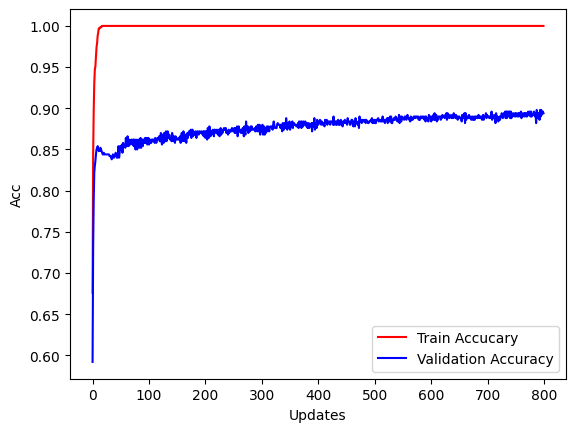

In [44]:

# we could have done this ourselves,
# but we should be aware of sklearn and its tools
from sklearn.metrics import accuracy_score


# setting hyperparameters and gettings epoch sizes
batch_size = 100
num_epochs = 800
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        # compute gradients given loss
        target_batch = targets_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        preds = torch.max(output, 1)[1]
        
        train_targs += list(targets_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(x_valid[slce])
        preds = torch.max(output, 1)[1]
        val_targs += list(targets_valid[slce].numpy())
        val_preds += list(preds.data.numpy())
        

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')

Changing the learning rate to 2e-4 achieves even better validation accuracy of 0.894 and I also note that it really helps the training accuracy to saturate. I theorize that since the batch normalization works by a running mean and variance that are updated over training that it helps stabilize and give momentum to the learning rate thus giving better validation accuracy. 

Just to validate that it is not the learning rate on its own I try the network without batch normalization but with a 2e-4 learning rate

In [45]:
#Hyperparameters
num_classes = 10
num_l1 = 512
num_l2 = 512
num_features = x_train.shape[1]

# define network
class Net(nn.Module):

    def __init__(self, num_features, num_hidden1,num_hidden2, num_output):
        super(Net, self).__init__()  
        # input layer
        self.W_1 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden1, num_features)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden1), 0))
        # hidden layer
        self.W_2 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden2, num_hidden1)))
        self.b_2 = Parameter(init.constant_(torch.Tensor(num_hidden2), 0))

        # Another hidden layer
        self.W_3 = Parameter(init.xavier_normal_(torch.Tensor(num_output, num_hidden2)))
        self.b_3 = Parameter(init.constant_(torch.Tensor(num_output), 0))


        # define activation function in constructor
        self.activation = torch.nn.ReLU()

    def forward(self, x):
        x = F.linear(x, self.W_1, self.b_1)
        x = self.activation(x)
        x = F.linear(x, self.W_2, self.b_2)
        x = self.activation(x) # added another activation function
        x = F.linear(x, self.W_3, self.b_3) # added another layer
        
        x = F.softmax(x, dim=1)
        return x


net = Net(num_features, num_l1,num_l2, num_classes)

optimizer = optim.Adam(net.parameters(), lr=2e-4,betas = (0.9, 0.999))
criterion = nn.CrossEntropyLoss()




Epoch  1 : Train Loss 0.227818 , Train acc 0.640000, Valid acc 0.610000
Epoch 11 : Train Loss 0.155885 , Train acc 0.944000, Valid acc 0.854000
Epoch 21 : Train Loss 0.150112 , Train acc 0.974000, Valid acc 0.856000
Epoch 31 : Train Loss 0.148462 , Train acc 0.983000, Valid acc 0.858000
Epoch 41 : Train Loss 0.147955 , Train acc 0.984000, Valid acc 0.860000
Epoch 51 : Train Loss 0.147573 , Train acc 0.987000, Valid acc 0.858000
Epoch 61 : Train Loss 0.147501 , Train acc 0.987000, Valid acc 0.858000
Epoch 71 : Train Loss 0.147467 , Train acc 0.987000, Valid acc 0.856000
Epoch 81 : Train Loss 0.147445 , Train acc 0.987000, Valid acc 0.856000
Epoch 91 : Train Loss 0.147430 , Train acc 0.987000, Valid acc 0.856000
Epoch 101 : Train Loss 0.147420 , Train acc 0.987000, Valid acc 0.858000
Epoch 111 : Train Loss 0.147412 , Train acc 0.987000, Valid acc 0.858000
Epoch 121 : Train Loss 0.147311 , Train acc 0.988000, Valid acc 0.854000
Epoch 131 : Train Loss 0.147305 , Train acc 0.988000, Valid a

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Acc'))

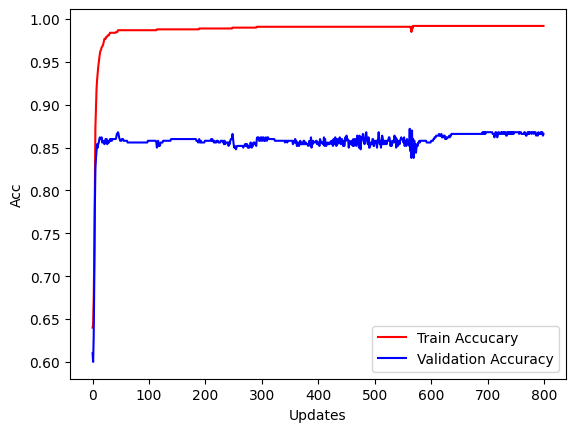

In [46]:
# setting hyperparameters and gettings epoch sizes
batch_size = 100
num_epochs = 800
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        # compute gradients given loss
        target_batch = targets_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        preds = torch.max(output, 1)[1]
        
        train_targs += list(targets_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(x_valid[slce])
        preds = torch.max(output, 1)[1]
        val_targs += list(targets_valid[slce].numpy())
        val_preds += list(preds.data.numpy())
        

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')

Here it is clearly seen without batchnormalization that the achived training accuracy never hits 1 and that the validation accuracy never reaches the same levels around 0.89. Thus I conclude that batch normalization indeed is benefitial for this problem

## Conclusion of Regularization Investigations

In this investigation, I tested various regularization methods on a deeper neural network, as regularization is intended to combat overfitting. The network used had an additional hidden layer with 512 units, ReLU activation, and Adam optimizer (learning rate 1e-5). The network was trained for 800 epochs to fully saturate the learning curve. 

### Benchmark Network:
- **Benchmark Performance:** The baseline network achieved a validation accuracy of **0.874**.

### L2 Regularization:
1. **L2 Regularization with weight decay of 0.1:**
   - This was too aggressive and did not allow the network to converge, with a maximum validation accuracy of **0.45**.
   - **Key Conclusion:** **Weight decay of 0.1 is too high** and hinders convergence.

2. **L2 Regularization with weight decay of 0.01:**
   - Achieved a validation accuracy of **0.872**, similar to the benchmark but slower to converge.
   - **Key Conclusion:** **Weight decay of 0.01** is still too aggressive, resulting in slow convergence.

3. **L2 Regularization with weight decay of 0.001:**
   - Comparable accuracy to the 0.01 decay rate but faster saturation of the learning curve.
   - **Key Conclusion:** **Weight decay of 0.001** offers the best balance of speed and accuracy but does not outperform the benchmark.

4. **L2 Regularization with weight decay of 0.0001:**
   - Achieved the same level of validation accuracy as the benchmark (**0.872**).
   - **Key Conclusion:** L2 regularization **does not improve the performance** of this network for this problem.

### L1 Regularization:
1. **L1 Regularization with 1e-4 parameter:**
   - Achieved a validation accuracy of **0.862**, which is lower than the benchmark.
   - **Key Conclusion:** L1 regularization with this parameter is **not beneficial**.

2. **L1 Regularization with 1e-6 parameter:**
   - Slight improvement in convergence, but the validation accuracy was still only **0.86**, slightly below the benchmark.
   - **Key Conclusion:** L1 regularization **does not help** in this case.

3. **L1 Regularization with 1e-8 parameter:**
   - Similar performance to the benchmark, indicating **no improvement**.
   - **Key Conclusion:** L1 regularization is **not effective** for this network, though it may help with more complex models prone to overfitting.

### Dropout Regularization:
1. **Dropout Rate of 0.5:**
   - Validation accuracy of **0.86**, with slower convergence indicating the dropout rate is too high.
   - **Key Conclusion:** **Dropout rate of 0.5** is too aggressive and slows learning.

2. **Dropout Rate of 0.1:**
   - Validation accuracy of **0.87**, hitting this accuracy faster but showing no significant improvement.
   - **Key Conclusion:** Dropout **does not provide a clear benefit** for this network.

### Batch Normalization:
1. **Batch Normalization with original learning rate (1e-5):**
   - Validation accuracy of **0.82**, indicating that batch normalization hindered learning.
   - **Key Conclusion:** **Batch normalization requires a higher learning rate** to be effective.

2. **Batch Normalization with a learning rate of 1e-4:**
   - Achieved a validation accuracy of **0.884**, the highest observed so far.
   - **Key Conclusion:** **Batch normalization with a higher learning rate significantly improves performance**.

3. **Batch Normalization with a learning rate of 2e-4:**
   - Achieved an even higher validation accuracy of **0.894**, with faster convergence.
   - **Key Conclusion:** Increasing the learning rate to **2e-4 with batch normalization yields the best results**. The running mean and variance in batch normalization stabilize learning and improve accuracy.

4. **Testing higher learning rate without Batch Normalization:**
   - Without batch normalization, the validation accuracy did not reach the same levels as with it, confirming that batch normalization is the key factor.
   - **Key Conclusion:** **Batch normalization is crucial** for improved performance when combined with a higher learning rate.

### **Final Summary:**
Overall, L2 and L1 regularization methods did not significantly improve performance in this instance. Dropout also showed no clear benefit. **Batch normalization with an increased learning rate of 2e-4 yielded the best validation accuracy of 0.894**, demonstrating that this regularization method, combined with a higher learning rate, is the most effective for this problem.

**Final Note:** These investigations have been somewhat superficial, and further tuning of the individual networks might yield better results. Additional trials, such as adjusting regularization parameters or network structure, could reveal more insights into optimal performance for this network.


### Lastly I wish to play a bit around and make a neural network with two extra layers, Adam optimizer and batch normalization 

In [50]:
#Hyperparameters
num_classes = 10
num_l1 = 512
num_l2 = 512
num_l3 = 512
num_features = x_train.shape[1]

# define network
class Net(nn.Module):

    def __init__(self, num_features, num_hidden1,num_hidden2,num_hidden3, num_output):
        super(Net, self).__init__()  
        # input layer
        self.W_1 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden1, num_features)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden1), 0))
        
        # Batch normalization after the first layer
        self.batch_norm1 = nn.BatchNorm1d(num_hidden1)
        
        # hidden layer
        self.W_2 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden2, num_hidden1)))
        self.b_2 = Parameter(init.constant_(torch.Tensor(num_hidden2), 0))
        
        # Batch normalization after the second layer
        self.batch_norm2 = nn.BatchNorm1d(num_hidden2)

        # Another hidden layer
        self.W_3 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden3, num_hidden2)))
        self.b_3 = Parameter(init.constant_(torch.Tensor(num_hidden3), 0))
        
        # Batch normalization after the third layer
        self.batch_norm3 = nn.BatchNorm1d(num_hidden3)
        
        # Another hidden layer
        self.W_4 = Parameter(init.xavier_normal_(torch.Tensor(num_output, num_hidden3)))
        self.b_4 = Parameter(init.constant_(torch.Tensor(num_output), 0))
        
        # Batch normalization after the fourth layer
        self.batch_norm4 = nn.BatchNorm1d(num_output)
        


        # define activation function in constructor
        self.activation = torch.nn.ReLU()

    def forward(self, x):
        x = F.linear(x, self.W_1, self.b_1)
        # apply batch normalization
        x = self.batch_norm1(x)
        x = self.activation(x)
        
        x = F.linear(x, self.W_2, self.b_2)
        # apply batch normalization
        x = self.batch_norm2(x)
        x = self.activation(x) # added another activation function
        x = F.linear(x, self.W_3, self.b_3) # added another layer
        # apply batch normalization
        x = self.batch_norm3(x)
        
        # Another hidden layer
        x = F.linear(x, self.W_4, self.b_4)
        # apply batch normalization
        x = self.batch_norm4(x)
        
        
        x = F.softmax(x, dim=1)
        return x


net = Net(num_features, num_l1,num_l2,num_l3, num_classes)

optimizer = optim.Adam(net.parameters(), lr=2e-4,betas = (0.9, 0.999))
criterion = nn.CrossEntropyLoss()



Epoch  1 : Train Loss 0.212861 , Train acc 0.719000, Valid acc 0.656000
Epoch 11 : Train Loss 0.170417 , Train acc 0.992000, Valid acc 0.878000
Epoch 21 : Train Loss 0.166804 , Train acc 1.000000, Valid acc 0.870000
Epoch 31 : Train Loss 0.166090 , Train acc 1.000000, Valid acc 0.868000
Epoch 41 : Train Loss 0.164641 , Train acc 1.000000, Valid acc 0.878000
Epoch 51 : Train Loss 0.163879 , Train acc 1.000000, Valid acc 0.876000
Epoch 61 : Train Loss 0.163132 , Train acc 1.000000, Valid acc 0.886000
Epoch 71 : Train Loss 0.162195 , Train acc 1.000000, Valid acc 0.878000
Epoch 81 : Train Loss 0.161508 , Train acc 1.000000, Valid acc 0.876000
Epoch 91 : Train Loss 0.160895 , Train acc 1.000000, Valid acc 0.878000
Epoch 101 : Train Loss 0.160185 , Train acc 1.000000, Valid acc 0.874000
Epoch 111 : Train Loss 0.159547 , Train acc 1.000000, Valid acc 0.878000
Epoch 121 : Train Loss 0.158991 , Train acc 1.000000, Valid acc 0.880000
Epoch 131 : Train Loss 0.158468 , Train acc 1.000000, Valid a

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Acc'))

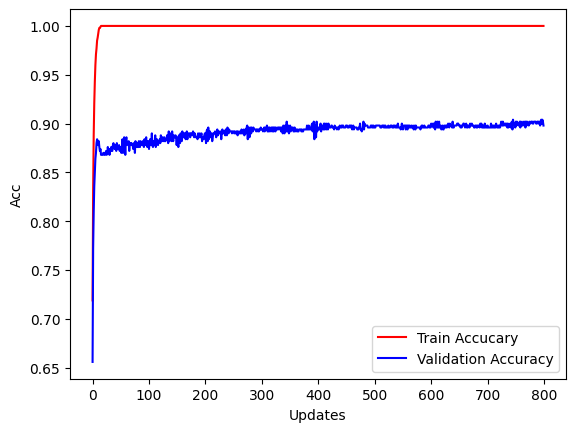

In [51]:
# setting hyperparameters and gettings epoch sizes
batch_size = 100
num_epochs = 800
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        # compute gradients given loss
        target_batch = targets_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        preds = torch.max(output, 1)[1]
        
        train_targs += list(targets_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(x_valid[slce])
        preds = torch.max(output, 1)[1]
        val_targs += list(targets_valid[slce].numpy())
        val_preds += list(preds.data.numpy())
        

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')

### Validation Accuracy and Model Insights

I achieved a **validation accuracy of 0.9**. Given that we only trained on 1000 images out of the total 50,000 available for training, this is a promising result.

I hypothesize that training on a larger share of the available MNIST images would further improve the performance of the network. However, based on the current results, I conclude that the following architecture works quite well:

- **Network architecture**: Deep neural network with 4 layers
- **Nodes per layer**: 512
- **Key techniques**:
    - Batch normalization
    - Adam optimization with a learning rate of \(2 \times 10^{-4}\)
    - Xavier initialization
    - ReLU activation

### Key Observations

One important observation is how quickly the description of the neural network architecture becomes complex. It is crucial to approach this process methodically, documenting each step and every change made to the model.

### Conclusion

The combination of these techniques and a deeper network architecture seems to provide solid performance for the MNIST dataset, even with a relatively small training sample size.


# **Exercise from the Book**

I do the following exercise which can be found at: http://neuralnetworksanddeeplearning.com/chap3.html 

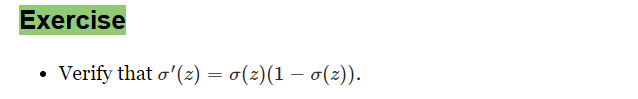

$$
\text { I wil now verify that } \sigma^{\prime}(z)=\sigma(z)(1-\sigma(z)) \text {. }
$$

First I get that the sigma function is given by:
$$

\sigma(z) = \frac{1}{1+e^{-z}}

$$


Differentiating this I get:
$$
\begin{align*}
&\frac{\partial \sigma(z)}{\partial z} =\frac{\partial (1+e^{-z})^{-1}}{\partial z}  \newline
&\text{I use chain rule and first differentiate the outer function} \newline
& \frac{\partial (1+e^{-z})^{-1}}{\partial z}  = -(1+e^{-z})^2 \cdot \frac{\partial (1+e^{-z})}{\partial z} \newline 
&\text{Then I differentiate the inner function} \newline
& -(1+e^{-z})^2 \cdot \frac{\partial (1+e^{-z})}{\partial z} = -(1+e^{-z})^{-2} \cdot (-e^{-z}) =  (1+e^{-z})^{-2} \cdot (e^{-z})
\end{align*}
$$

I then recall that 
$$
\sigma(z) = \frac{1}{1+e^{-z}} 
$$

I then use this to simplify the expression:

$$
(1+e^{-z})^{-2} \cdot (e^{-z}) = \sigma(z)^2 \cdot e^{-z}
$$

I then use the definition of the sigma function to solve for $ e^{-z} $

$$
\begin{align*}
\sigma(z) = \frac{1}{1+e^{-z}} \newline
\sigma(z) \cdot (1+e^{-z}) = 1 \newline 
(1+e^{-z}) = \frac{1}{\sigma(z)} \newline 
e^{-z} = \frac{1}{\sigma(z)}-1 = \frac{1-\sigma(z)}{\sigma(z)}
\end{align*}
$$



I use this so simplify the above expression 

$$
 \sigma(z)^2 \cdot e^{-z} = \sigma(z)^2 \cdot  \frac{1-\sigma(z)}{\sigma(z)} = \sigma(z) \cdot (1-\sigma(z)) \newline 
 \newline

$$

Q.E.D